In [21]:
import pandas as pd
import numpy as np
from pandas import read_excel
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime

from fbprophet import Prophet
from fbprophet.plot import plot

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid

from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import random
import itertools

#import json    #for saving the model
#from fbprophet import model_to_json, model_from_json
#from fbprophet.serialize import model_to_json, model_from_json
import pickle

plt.style.use('fivethirtyeight') # For plots
import os
#Author: Vatsala

In [22]:
#import fbprophet
#fbprophet.__version__

In [23]:
#import utils

In [24]:
plot_file_path ="../prophetForecastPlots/Plot"
plot_data_path ="../plotData/"

In [25]:
#### Specify Plot ID

In [26]:
plotId = "1"

In [27]:
#### Create directory for storing facebook prophet forecasts

In [28]:
# define the name of the directory to be created for the png outputs

path_image = plot_file_path+str(plotId)

try:
    if not os.path.exists(path_image):     
         os.mkdir(path_image)
except OSError:
    print ("Creation of the directory %s failed" % path_image)
else:
    print ("Successfully created the directory %s " % path_image)

Successfully created the directory ../prophetForecastPlots/Plot1 


In [29]:
#****** Running Forecast for Plot 1 *******  Note: Data has been QC-ed

#read Plot 1 data
data = read_excel('../plotData/plotData_'+plotId+'.xlsx', sheet_name='Sheet1', index_col=13, parse_dates=[13])    

In [30]:
#print(data.head(10))
#data.dtypes

In [31]:
#This dataframe will be used for running in the Prophet model
#Extract only datetime and flux from the series

dataframe = DataFrame()
dataframe['Flux']  = data['flux']
dataframe['ghg']   = data['ghg']
#dataframe

## Forecasting CH4 greenhouse gas

In [32]:
### Plot CH4 gas
df_CH4dry = dataframe[dataframe['ghg'] == 'CH4_dry']

In [21]:
### Feature Engineering

In [28]:
#create some time series features to see how the trends are impacted by day of week, hour, time of year, etc.
#Feature Engineering  - feature used to visualise the data
def create_features(df, label=None):
    '''Create time series features from date time index'''
    df = df.copy()
    df['date']        = df.index #df['DateTime']  #.index
    df['hour']        = df['date'].dt.hour
    df['dayofmonth']  = df['date'].dt.day
    df['month']       = df['date'].dt.month
    df['year']        = df['date'].dt.year
    df['weekofyear']  = df['date'].dt.weekofyear
    df['dayofweek']   = df['date'].dt.dayofweek
    df['dayname']     = df['date'].dt.day_name() 
   
    X = df[['year', 'month', 'dayofmonth', 'weekofyear', 'hour', 'dayofweek', 'dayname']]  #features should be a matrix
    
    if label:
        y = df[label]   #target
        return X,y
    return X

In [ ]:
X, y            = create_features(df_CH4dry, 'Flux')    #the target is the flux in this case; the features = X (as shown above)
features_target = pd.concat([X, y], axis=1)  #concatenate the features and the target
features_target.head()

In [ ]:
#plt.figure(figsize=(30,20))
sns_plot = sns.pairplot(features_target.dropna(), diag_kind="kde", markers="+", hue='hour', 
                  x_vars=['month', 'dayofmonth','weekofyear','hour'],
                  y_vars='Flux',
                      
                  plot_kws=dict(s=70, edgecolor="b", linewidth=4),
                  diag_kws=dict(shade=True))

#year_value = features_target['year'].iloc[0]      

plt.suptitle('CH4 Gas Flux by Month, Day of month, Week of Year and by hour/ '+str(features_target['year'].iloc[0])+' - Plot '+plotId, fontsize=22, y=1.02)

sns_plot.fig.set_figwidth(20)
sns_plot.fig.set_figheight(10)

#For plotting month
sns_plot.axes[0][0].set_xlim(1,6)
sns_plot.axes[0][0].set_ylim(None, None)

##For plotting year
#df1_year=features_target.dropna(axis=0)
## Get hold of the 'Axes' objects
#sns_plot.axes[0][0].set_xticks(df1_year['year'])
#sns_plot.axes[0][0].set_ylim(None, None)

#Save boxplot as a file
#output file name
plot_file_name="../prophetForecastPlots/Plot"+plotId+"/CH4_gasflux_Plot"+plotId+"_features.png" 
# save as png
sns_plot.savefig(plot_file_name)

#plt.show()

### The second part of the code uses Prophet model to draw forecast on the historical data - for the given Plot

#### The reason to use Prophet is that:
It can be seen from the above plot (Flux Data) that there is roughly constant level (the mean of hourly flux). The seasonal fluctuation and random fluctuations roughly are constant in size over time. This suggests that it’s probably appropriate to describe the data using an additive model which is Prophet built on.

### Split the data into training and test data set for CH4_dry gas 
Training data set - March till May 2019

Test data set     - June 2019 

In [31]:
#Train Test - split data
split_date = '31-May-2019'

dataf = df_CH4dry.dropna(axis=0)  #HERE USE DATAFRAME not features_target(this is for visualising)

dataframe_train_CH4dry = dataf.loc[dataf.index <= split_date].copy()
dataframe_test_CH4dry  = dataf.loc[dataf.index > split_date].copy()

#print(dataframe_test_CH4dry.head(10))
#print(dataframe_train_CH4dry.tail(10))

In [32]:
dataframe_train_CH4dry.to_csv('mineap.csv')

### Visualise the training and test data sets

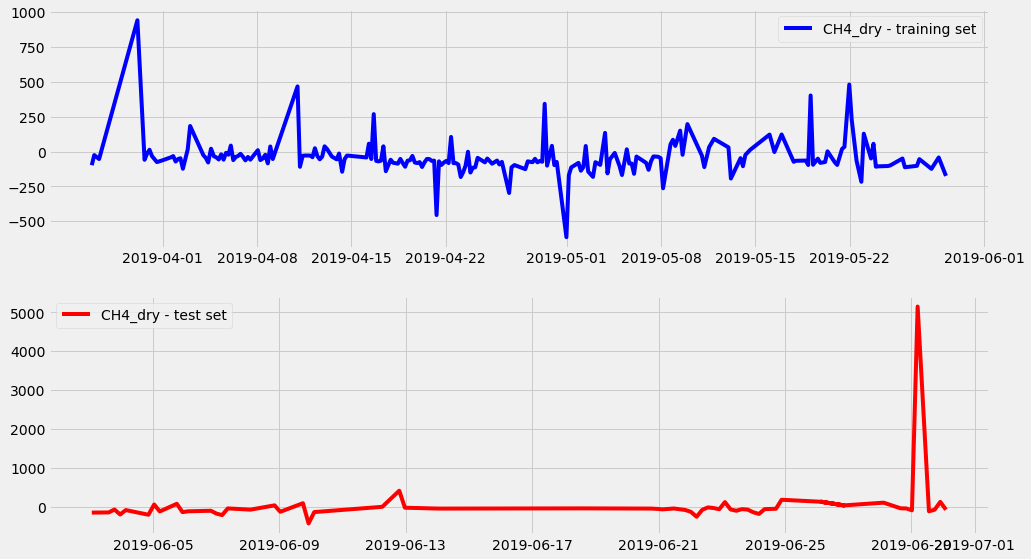

In [33]:
#Visualise the training and test data sets
#fig, (axs) = plt.subplots(ncols=1, nrows=2, sharey=False, figsize=(25,12))
#fig.suptitle("Training v/s Test data sets", fontsize=22)
#fig.tight_layout(pad=3.0)

#df_CH4dry = dataframe[dataframe['ghg'] == 'CH4_dry']
fig, axs = plt.subplots(2, sharey=False, figsize=(15,9))  #(1, figsize=(15,12))
axs[0].plot(dataframe_train_CH4dry['Flux'], color='blue')

axs[1].plot(dataframe_test_CH4dry['Flux'], color='red')

#axs[0].plot(dataframe_train_CH4dry['Flux'], color='blue')
#axs[0].set_xticklabels(dataframe_train_CH4dry.index, rotation=20, ha='right')

#axs[1].plot(dataframe_test_CH4dry['Flux'], color='red')
#axs[1].set_xticklabels(dataframe_test_CH4dry.index, rotation=20, ha='right')

axs[0].legend(['CH4_dry - training set'])
axs[1].legend(['CH4_dry - test set'])

plt.show()

### Remove any outliers from the training datasets  - 
- Do we remove outliers???
- test data sets hold few outliers

### Check for any seasonal patterns in the gas flux

In [17]:
### Format training data for prophet model using ds and y

In [18]:
#dataframe_train_CH4dry

In [19]:
dataframe_train_CH4dry = dataframe_train_CH4dry.drop('ghg', axis=1)  #, errors='ignore'
#dataframe_train_CH4dry = dataframe_train_CH4dry.reset_index()

#dataframe_train_CH4dry

In [20]:
#### Do the same for the test data set

In [21]:
dataframe_test_CH4dry = dataframe_test_CH4dry.drop('ghg', axis=1)   #, errors='ignore'

#dataframe_test_CH4dry 

In [22]:
# Format training data for prophet model using ds and y
#dataframe_train_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'}).head()

#dataframe_train_CH4dry_frct = dataframe_train_CH4dry_frct.rename(columns={'DateTime': 'ds', 'Flux': 'y'}).head()
#dataframe_train_CH4dry_frct

In [23]:
#dataframe_train_CH4dry.plot(style='-', figsize=(15,5), title='Flux Data')

### ### Visualising gas flux for one particular day

In [24]:
#Choose one particular gas
#Choose one day from the dataset
dataframe_train_CH4dry_hourly = dataframe_train_CH4dry.copy()

df         = DataFrame()
df['date'] = pd.to_datetime(dataframe_train_CH4dry_hourly.index)  
#print(df['date'])

start_date = '2019-04-25'
end_date   = '2019-04-26'
#mask = (df['date'] >= start_date) & (df['date'] < end_date)
#print(mask)

df1 = dataframe_train_CH4dry_hourly[((dataframe_train_CH4dry_hourly.index >= start_date) & (dataframe_train_CH4dry_hourly.index < end_date))]
                                    
#print(df1)

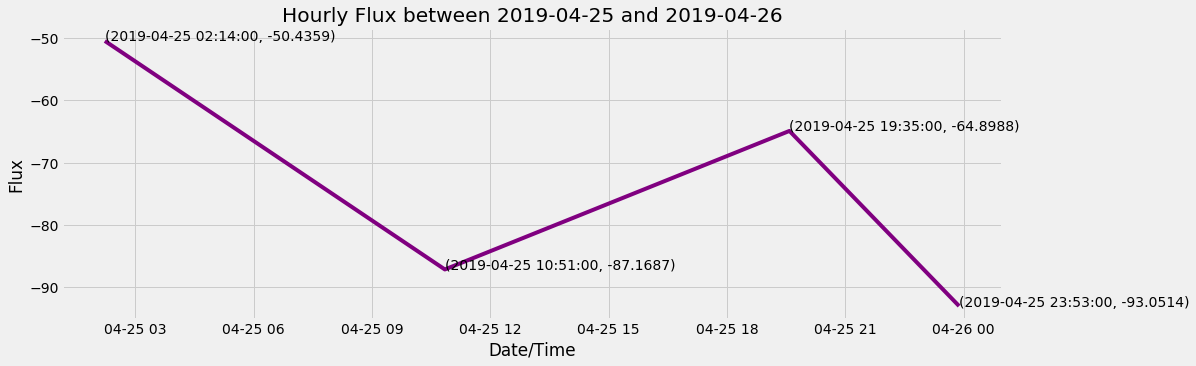

In [25]:
# Create figure and plot space
df2 = df1.reset_index()

fig, ax = plt.subplots(figsize=(15, 5))

# Add x-axis and y-axis
ax.plot(df2['DateTime'],
        df2['Flux'],
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date/Time",
       ylabel="Flux",
       title="Hourly Flux between "+start_date+" and "+end_date)

#plt.plot(A,B)
for xy in zip(df2['DateTime'], df2['Flux']):                                     
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data') 


#plt.grid()   
plt.show()

##### Note: There is a decrease from night till early morning, increase from morning till evening.

### Visualising gas flux per day of week

In [26]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

seriesObj_f = features_target['dayofweek']

df_f = seriesObj_f.to_frame()

#Merge with dataframe

df_all = dataframe.copy()

df_merge_col_all = pd.merge(df_f, df_all, on='DateTime')


#df_merge_col_all

for index, row in df_merge_col_all.iterrows():
    row.dayofweek = days[int(row.dayofweek)]  #convert datetime object to string
    df_merge_col_all.loc[index, 'dayofweek'] = row.dayofweek

#df_merge_col_all.reset_index(drop=True, inplace=True)

df_merge_col_ch4 = df_merge_col_all[df_merge_col_all['ghg'] == 'CH4_dry']

#df_merge_col_1.reset_index(drop=True, inplace=True)
#df_merge_col_1

df_merge_col_ch4.reset_index(drop=True, inplace=True)
#df_merge_col_ch4

dayofweek       Flux      ghg
0      Tuesday   -98.0130  CH4_dry
1      Tuesday   -25.5522  CH4_dry
2    Wednesday   -54.1259  CH4_dry
3     Saturday   940.7205  CH4_dry
4     Saturday   -59.4622  CH4_dry
..         ...        ...      ...
272   Saturday  5148.4019  CH4_dry
273   Saturday  -114.9512  CH4_dry
274   Saturday   -74.6339  CH4_dry
275   Saturday   127.2111  CH4_dry
276     Sunday   -74.0129  CH4_dry

[277 rows x 3 columns]

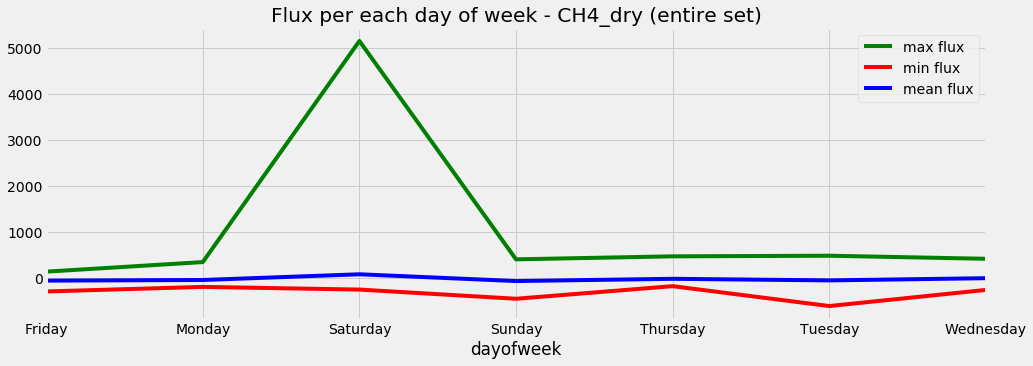

In [27]:
#Plot the training dataset
fig, ax = plt.subplots(figsize=(15, 5))

ax = plt.gca()

df_all = df_merge_col_ch4
df_all.groupby('dayofweek').max().plot(kind='line', ax=ax, color='green')
df_all.groupby('dayofweek').min().plot(kind='line', ax=ax, color='red')
df_all.groupby('dayofweek').mean().plot(kind='line', ax=ax, color='blue')
ax.legend(["max flux", "min flux", "mean flux"])
ax.title.set_text("Flux per each day of week - CH4_dry (entire set)")
plt.show()

In [28]:
#### Visualising Test set

In [29]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

seriesObj_f = features_target['dayofweek']

df_f = seriesObj_f.to_frame()

#Merge with test dataframe
df_te = dataframe_test_CH4dry.copy()

df_merge_col_1 = pd.merge(df_f, df_te, on='DateTime')


df_merge_col_1

for index, row in df_merge_col_1.iterrows():
    row.dayofweek = days[int(row.dayofweek)]  #convert datetime object to string
    df_merge_col_1.loc[index, 'dayofweek'] = row.dayofweek
    #print(index, row.dayofweek, '\n')

df_merge_col_1.reset_index(drop=True, inplace=True)
#df_merge_col_1

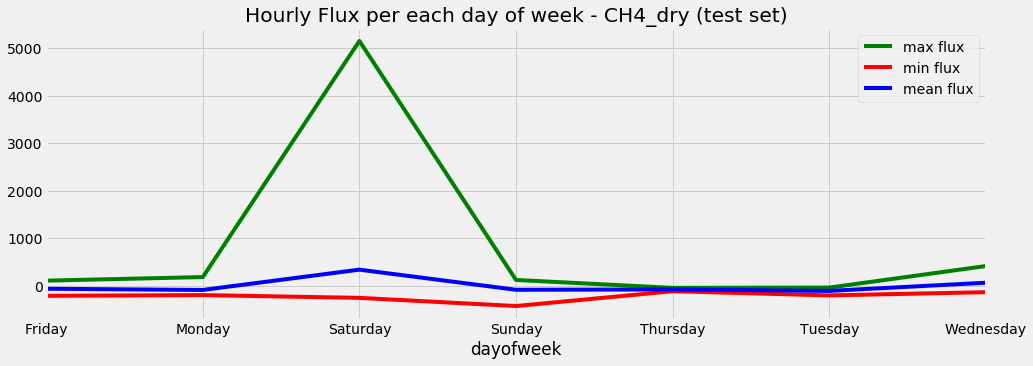

In [30]:
#Plot the test dataset
fig, ax = plt.subplots(figsize=(15, 5))

ax = plt.gca()

df = df_merge_col_1
#print(df.groupby('dayofweek').sum())
df.groupby('dayofweek').max().plot(kind='line', ax=ax, color='green')
df.groupby('dayofweek').min().plot(kind='line', ax=ax, color='red')
df.groupby('dayofweek').mean().plot(kind='line', ax=ax, color='blue')
ax.legend(["max flux", "min flux", "mean flux"])
ax.title.set_text("Hourly Flux per each day of week - CH4_dry (test set)")
#plt.show()

##### Note: Maximum flux in training data set = 1000

### Generate Simple Prophet Model for CH4_dry gas 

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


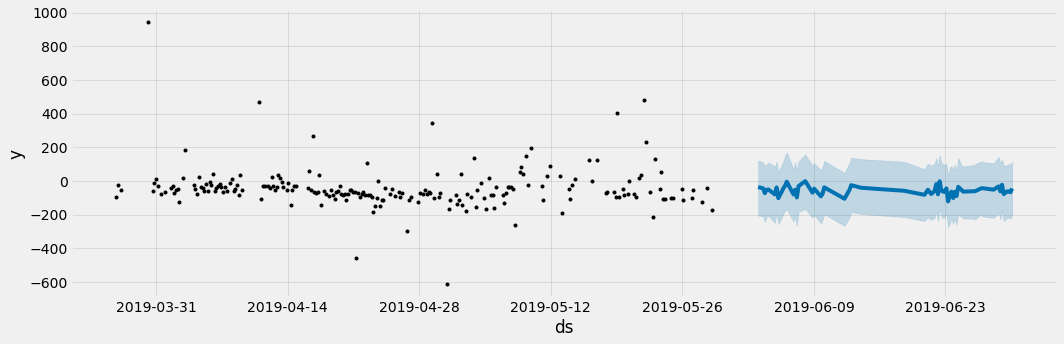

In [31]:
m3 = Prophet() 
m3.fit(dataframe_train_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'}))
forecast1_ch4 = m3.predict(df=dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'}))

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m3.plot(forecast1_ch4,ax=ax)
plt.show()

### Plot the components of the model

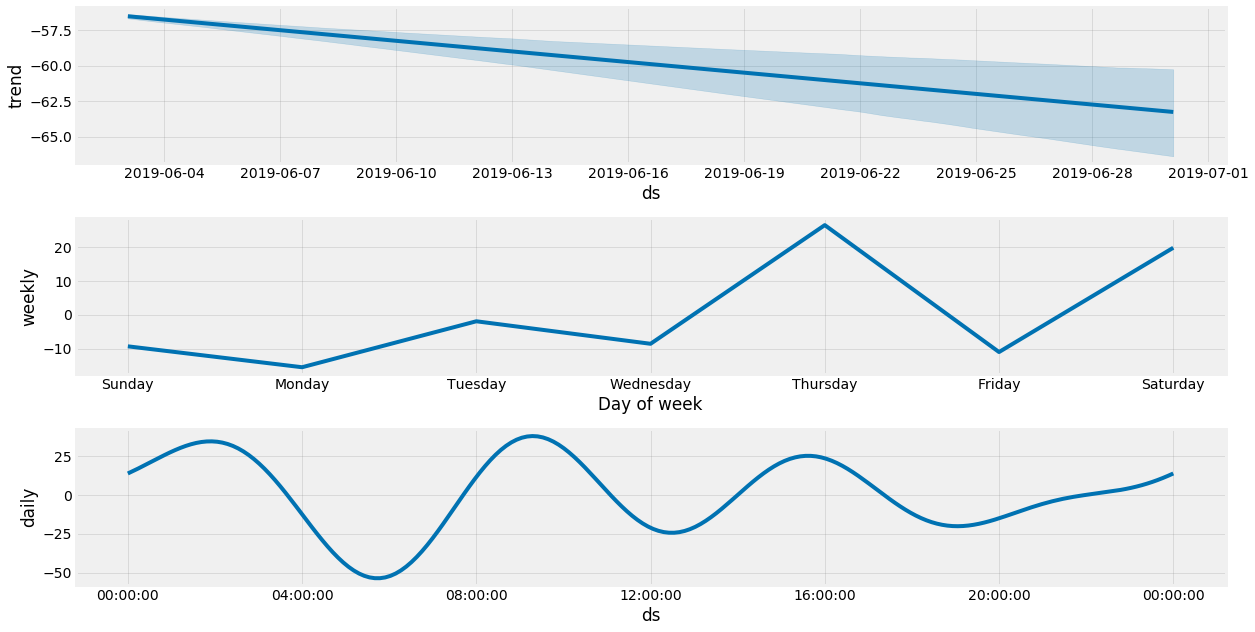

In [32]:
fig = m3.plot_components(forecast1_ch4)
fig.set_figwidth(20)

### Compare Actual to Forecasted Simple Model

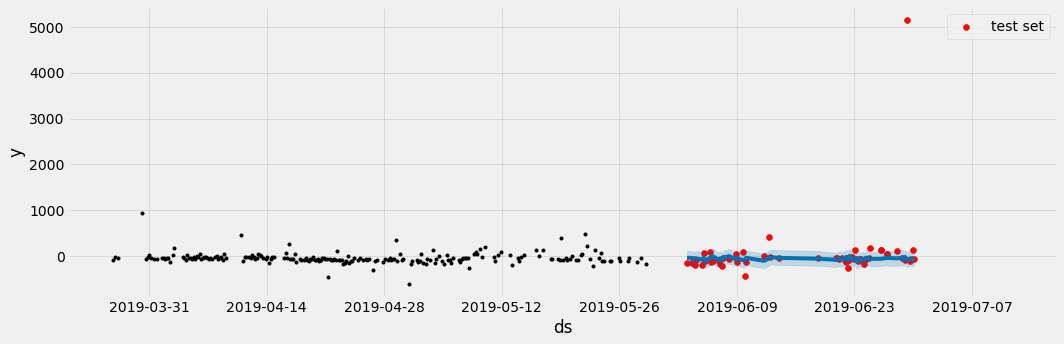

In [33]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_CH4dry.index, dataframe_test_CH4dry['Flux'], color='r', label="test set")
ax.legend()
fig = m3.plot(forecast1_ch4, ax=ax)

### Compare the gas flux in test set and in forecasted set

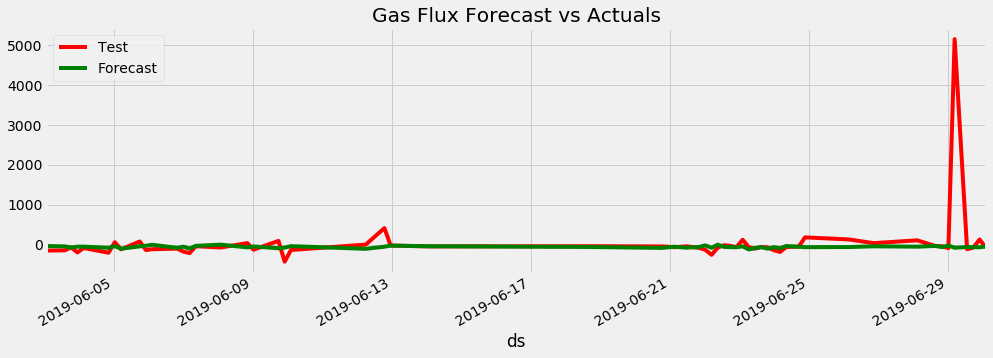

In [34]:
df1=dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'})

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df1.plot(kind='line', x='ds', y='Flux', color='red', label='Test', ax=ax)
#X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
forecast1_ch4.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

### Draw some more comparisons - e.g compare first week of June

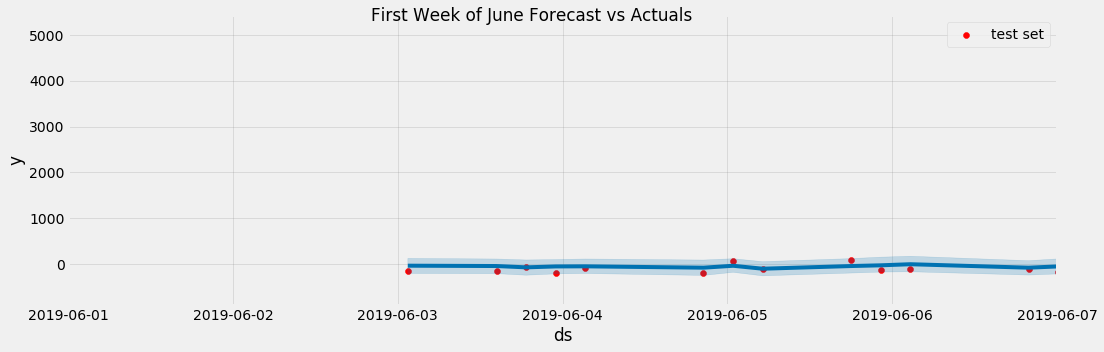

In [35]:
df = df_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df.ds, df['y'], color='r', label="test set")
ax.legend()

#fig = m3.plot(X_tst_forecast, ax=ax)

fig = m3.plot(forecast1_ch4, ax=ax)

ax.set_xlim([datetime.date(2019, 6, 1), datetime.date(2019, 6, 7)])
#ax.set_xbound(lower='2019-06-01', upper='2019-06-07')
ax.set_ylim(None, None)

plot = plt.suptitle('First Week of June Forecast vs Actuals')

#### Now, we will predict by creating future dataframe next dates of train data. 
make_future_dataframe has include_history = True by default.

So the prediction will be done for train data as well.

### Forecast for next 2 months

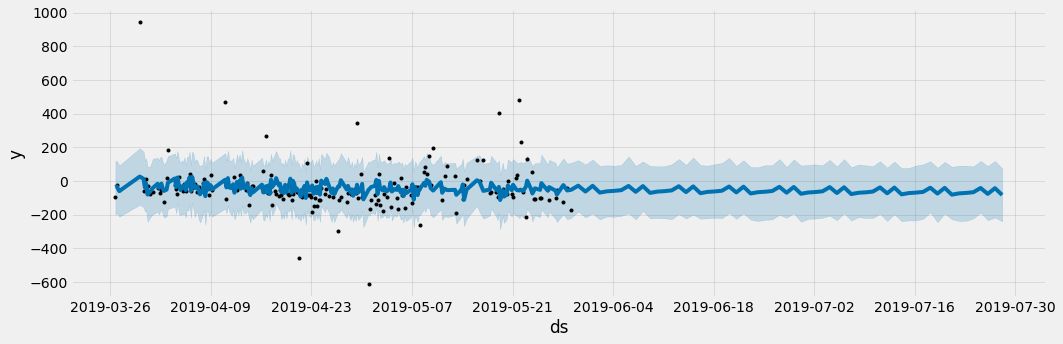

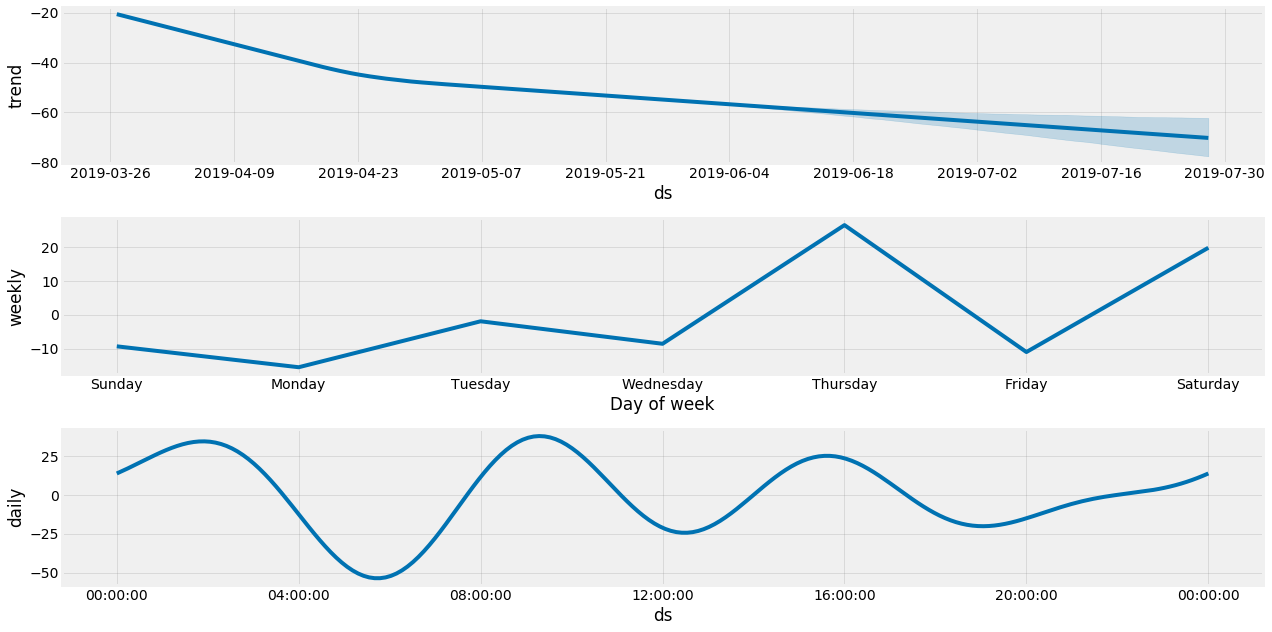

In [36]:
#future_2W        = pro_regressor.make_future_dataframe(periods=14, freq='D', include_history = False) 
#forecast_weeks2W = pro_regressor.predict(future_2W)

## Plot the forecast
#f, ax = plt.subplots(1)
#f.set_figheight(5)
#f.set_figwidth(15)
#fig = pro_regressor.plot(forecast_weeks2W,ax=ax)
#plt.show()

## Plot the components of the model
#fig1 = pro_regressor.plot_components(forecast_hours2W)
#fig1.set_figwidth(20)

future2       = m3.make_future_dataframe(periods=30*2, freq='D')  
forecast2_ch4 = m3.predict(future2)

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m3.plot(forecast2_ch4,ax=ax)
plt.show()

# Plot the components of the model
fig1 = m3.plot_components(forecast2_ch4)
fig1.set_figwidth(20)

### Actuals v/s Forecast (simple model)

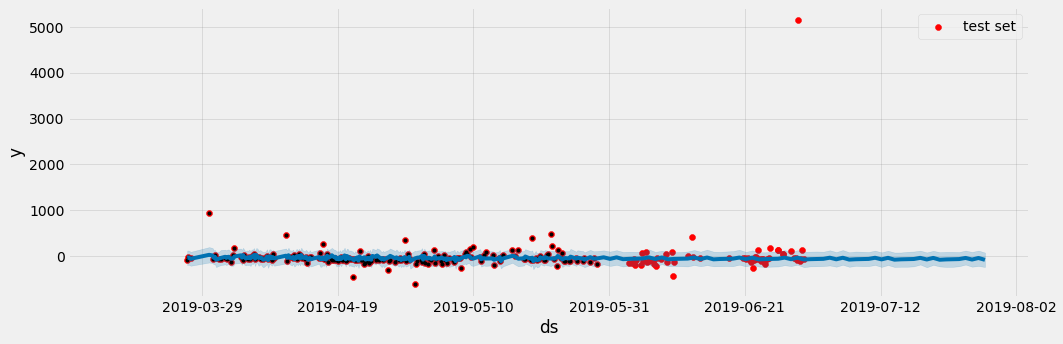

In [37]:
#df             = dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})
df = df_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})
#X_tst_forecast = m3.predict(df)

#m3 = Prophet() 
#m3.fit(dataframe_train_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'}))
#forecast1_ch4 = m3.predict(df=dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'}))


# Plot the forecast with the actuals
f1, ax = plt.subplots(1)
f1.set_figheight(5)
f1.set_figwidth(15)
ax.scatter(df.ds, df['y'], color='r', label="test set")
ax.legend()
#fig2 = m3.plot(X_tst_forecast, ax=ax) 

fig2 = m3.plot(forecast2_ch4, ax=ax)

### Plot the forecast with the actuals for first week of June

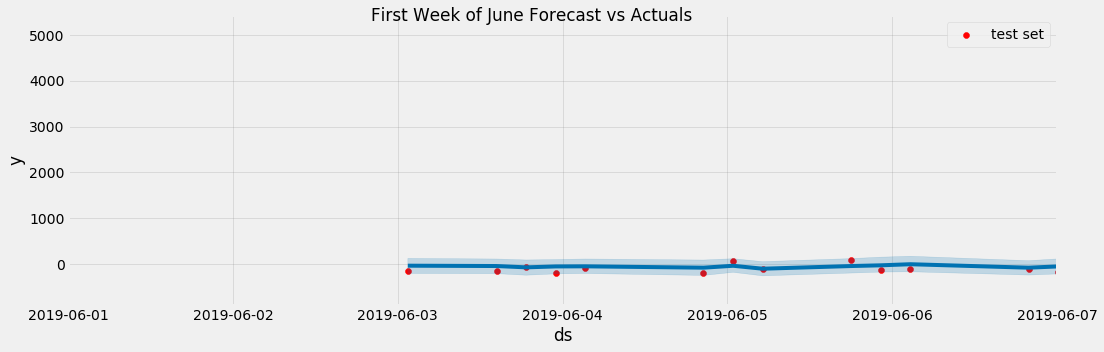

In [38]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df.ds, df['y'], color='r', label="test set")
ax.legend()

#fig = m3.plot(X_tst_forecast, ax=ax)

fig = m3.plot(forecast1_ch4, ax=ax)

ax.set_xlim([datetime.date(2019, 6, 1), datetime.date(2019, 6, 7)])
#ax.set_xbound(lower='2019-06-01', upper='2019-06-07')
ax.set_ylim(None, None)

plot = plt.suptitle('First Week of June Forecast vs Actuals')

### Measure the performance of the model

In [39]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
#dataframe_test_CH4dry['Flux']

In [41]:
forecast1_ch4[['ds', 'yhat']].to_excel('forecast1_ch4.xlsx')

In [42]:
mape = mean_absolute_percentage_error(dataframe_test_CH4dry['Flux'],forecast1_ch4['yhat'])
print("MAPE",round(mape,4))

MAPE 834.025


In [43]:
#temp_x = DataFrame()
#temp_x = read_excel('./PerformanceMetric/CH4_SimpleModel_sample.xlsx', sheet_name='Sheet1', skiprows=[-1]) 

#actual = temp_x[["index1","y"]]


#foreca = temp_x[['index2', 'yhat']]

#mape = mean_absolute_percentage_error(actual['y'],foreca['yhat'])
#print("MAPE",round(mape,4))

### Cross Validation using the simple model

In [44]:
#horizon = how many days are we going to make forecast 
#period  = space between 2 or more training periods (normally 0.5 * horizon)
#initial = size of training period (normally 3* horizon)

df_cv = cross_validation(m3, initial='42 days', period='7 days', horizon = '14 days')   
df_p  = performance_metrics(df_cv)
df_p.to_csv("CrossValidation_m3.csv")
#df_p

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00


In [45]:
#fig3 = plot_cross_validation_metric(df_cv, metric='mape')

### Save the model

In [46]:
pkl_path = "./MyProphetModels/CH4/SimpleModel_CH4.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(m3, f)
    
# save the dataframe
forecast1_ch4.to_pickle("./MyProphetModels/CH4/simpleModel_forecast1_ch4_testset.pkl")
forecast2_ch4.to_pickle("./MyProphetModels/CH4/simpleModel_forecast2_ch4_1monthforecast.pkl")
print("*** Data Saved ***")

# To read the Prophet model object
#with open(pkl_path, 'rb') as f:
#    m = pickle.load(f)

#fcast = pd.read_pickle("path/to/data/forecast.pkl")

*** Data Saved ***


### Generate Model with Tuned Parameters (using HyperParameter Tuning)

### Hyperparameter Tuning
- do hyperparameter tuning using ParameterGrid from sklearn:
   - Hyper Parameters: (as advised by fbProphet authors to be tunable)
     - changepoint_prior_scale
     - seasonality_prior_scale
     - seasonality_mode: additive/multiplicative seasonality (in this case, the seasonality looks more additive)
     - uncertainty intervals - mcmc (bayesian sampling)   (Not Tunable)
- add changepoints, add holiday effect
- do forecast - hourly, daily, weekly
- add met data

### Prophet Model Tuning

In [47]:
params_grid = {
                'seasonality_prior_scale':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 2, 4, 6, 8, 10], # range [0.01, 10]
                'changepoint_prior_scale':[0.05, 0.1, 0.2, 0.3, 0.4, 0.5],    #range [0.001, 0.5]
                'n_changepoints'         :[25,75,125]
              } 

grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 216


In [48]:
def get_dates(df, start_date, end_date):
    #series_dates = forecast1_ch4['ds']
    
    #start_date = pd.to_datetime('2019-05-29') #, utc= True)
    #end_date   = pd.to_datetime('2019-06-29') #, utc= True)

    start_date = pd.to_datetime(start_date) #, utc= True)
    end_date   = pd.to_datetime(end_date) #, utc= True) 
    
    series_dates = df.copy()
    series_dates = series_dates.reset_index().drop('ghg', axis=1)
    #series_dates['ds'] = pd.to_datetime(series_dates['ds'])
    series_dates

    mask = (series_dates['DateTime'] > start_date) & (series_dates['DateTime'] < end_date)
    filtered_df = series_dates.loc[mask]
    #filtered_df = filtered_df.rename(columns={'DateTime': 'ds', 'Flux': 'y'})

    return filtered_df

In [77]:
start_date = '2019-05-29'
end_date   = '2019-06-29'

actual     = get_dates(dataf, start_date, end_date)  #30 days forecast - to retrieve the dates

model_parameters = pd.DataFrame(columns = ['MAPE', 'Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p) 
    #print('\n')
    random.seed(0)
    
    #weekly_seasonality=False,
    #daily_seasonality=True,
    #yearly_seasonality=False,

    tuned_model = Prophet(changepoint_prior_scale=p['changepoint_prior_scale'],
                          seasonality_prior_scale=p['seasonality_prior_scale'],
                          n_changepoints=p['n_changepoints'],
                          interval_width=0.95
                         )
    tuned_model.fit(dataframe_train_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'}))
    
    #by default, include_history=true, it means it will include train data as well
    #future3       = tuned_model.make_future_dataframe(periods=30, freq='D', include_history = False) 
    future3 = tuned_model.predict(df=dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'}))

    #Calculate the performance metric
    MAPE = mean_absolute_percentage_error(y_true=dataframe_test_CH4dry['Flux'], y_pred=future3['yhat'])
    print('Mean Absolute Percentage Error (MAPE)-------------------', MAPE)
    model_parameters = model_parameters.append({'MAPE': MAPE, 'Parameters': p}, ignore_index=True)
    print('\n')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'changepoint_prior_scale': 0.05, 'n_changepoints': 25, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 578.9357741895794


{'changepoint_prior_scale': 0.05, 'n_changepoints': 25, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 792.5169910132904


{'changepoint_prior_scale': 0.05, 'n_changepoints': 25, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 824.3574416133675


{'changepoint_prior_scale': 0.05, 'n_changepoints': 25, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 834.8984412153163


{'changepoint_prior_scale': 0.05, 'n_changepoints': 25, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 831.3369198319867


{'changepoint_prior_scale': 0.05, 'n_changepoints': 25, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 769.4401604517858


{'changepoint_prior_scale': 0.05, 'n_changepoints': 25, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 834.7300290677913


{'changepoint_prior_scale': 0.05, 'n_changepoints': 25, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 829.4401088297416


{'changepoint_prior_scale': 0.05, 'n_changepoints': 25, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 828.601584611156


{'changepoint_prior_scale': 0.05, 'n_changepoints': 25, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 832.6606326556058


{'changepoint_prior_scale': 0.05, 'n_changepoints': 25, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 831.1675841734384


{'changepoint_prior_scale': 0.05, 'n_changepoints': 25, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 834.0249793232778


{'changepoint_prior_scale': 0.05, 'n_changepoints': 75, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 519.5358334511737


{'changepoint_prior_scale': 0.05, 'n_changepoints': 75, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 759.1225211832514


{'changepoint_prior_scale': 0.05, 'n_changepoints': 75, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 784.9908491369363


{'changepoint_prior_scale': 0.05, 'n_changepoints': 75, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 802.5736145783497


{'changepoint_prior_scale': 0.05, 'n_changepoints': 75, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 786.7833214477711


{'changepoint_prior_scale': 0.05, 'n_changepoints': 75, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 793.2042541034821


{'changepoint_prior_scale': 0.05, 'n_changepoints': 75, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 812.6177881799302


{'changepoint_prior_scale': 0.05, 'n_changepoints': 75, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 808.345572522051


{'changepoint_prior_scale': 0.05, 'n_changepoints': 75, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 809.3757295329782


{'changepoint_prior_scale': 0.05, 'n_changepoints': 75, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 776.6918234943242


{'changepoint_prior_scale': 0.05, 'n_changepoints': 75, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 796.9143642328343


{'changepoint_prior_scale': 0.05, 'n_changepoints': 75, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 795.4760366198061


{'changepoint_prior_scale': 0.05, 'n_changepoints': 125, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 548.5857765617756


{'changepoint_prior_scale': 0.05, 'n_changepoints': 125, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 763.0554979294496


{'changepoint_prior_scale': 0.05, 'n_changepoints': 125, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 794.2111835508844


{'changepoint_prior_scale': 0.05, 'n_changepoints': 125, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 790.0688102411025


{'changepoint_prior_scale': 0.05, 'n_changepoints': 125, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 782.8839537962776


{'changepoint_prior_scale': 0.05, 'n_changepoints': 125, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 794.7941807581255


{'changepoint_prior_scale': 0.05, 'n_changepoints': 125, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 793.19508083852


{'changepoint_prior_scale': 0.05, 'n_changepoints': 125, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 792.1277249953482


{'changepoint_prior_scale': 0.05, 'n_changepoints': 125, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 792.1692677943211


{'changepoint_prior_scale': 0.05, 'n_changepoints': 125, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 794.074203478684


{'changepoint_prior_scale': 0.05, 'n_changepoints': 125, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 791.4026429989641


{'changepoint_prior_scale': 0.05, 'n_changepoints': 125, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 791.772140701177


{'changepoint_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 256.55319213738454


{'changepoint_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 431.8043424050016


{'changepoint_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 454.6518143705705


{'changepoint_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 431.6068185219546


{'changepoint_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 432.3539547032613


{'changepoint_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 445.3262715416533


{'changepoint_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 466.2735069371234


{'changepoint_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 426.5089438812299


{'changepoint_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 434.29901935715066


{'changepoint_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 436.9812312792936


{'changepoint_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 434.80494125374076


{'changepoint_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 433.8495928384984


{'changepoint_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 249.0863810394132


{'changepoint_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 456.8643260229987


{'changepoint_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 449.2562885567714


{'changepoint_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 462.57443110696397


{'changepoint_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 452.1258945159284


{'changepoint_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 452.8910791483494


{'changepoint_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 456.43898784801155


{'changepoint_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 453.20543878263015


{'changepoint_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 451.54145817178755


{'changepoint_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 447.76477654070834


{'changepoint_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 462.97069246241796


{'changepoint_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 458.98000085879636


{'changepoint_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 255.57418861007756


{'changepoint_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 428.9657507307813


{'changepoint_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 473.2900593915514


{'changepoint_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 473.1416053821082


{'changepoint_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 478.11898055882585


{'changepoint_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 483.2098478842659


{'changepoint_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 461.47751030036864


{'changepoint_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 468.54014701158064


{'changepoint_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 451.67027407756706


{'changepoint_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 474.8319134729309


{'changepoint_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 483.5762758655979


{'changepoint_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 468.42285117312866


{'changepoint_prior_scale': 0.2, 'n_changepoints': 25, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 142.26640808865994


{'changepoint_prior_scale': 0.2, 'n_changepoints': 25, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 340.83836583050584


{'changepoint_prior_scale': 0.2, 'n_changepoints': 25, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 364.7674610669148


{'changepoint_prior_scale': 0.2, 'n_changepoints': 25, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 348.20070071131954


{'changepoint_prior_scale': 0.2, 'n_changepoints': 25, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 364.810463054684


{'changepoint_prior_scale': 0.2, 'n_changepoints': 25, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 355.30819501738574


{'changepoint_prior_scale': 0.2, 'n_changepoints': 25, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 359.95251284033793


{'changepoint_prior_scale': 0.2, 'n_changepoints': 25, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 367.8780173956255


{'changepoint_prior_scale': 0.2, 'n_changepoints': 25, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 365.5876400261111


{'changepoint_prior_scale': 0.2, 'n_changepoints': 25, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 371.15922860837577


{'changepoint_prior_scale': 0.2, 'n_changepoints': 25, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 369.24522596534473


{'changepoint_prior_scale': 0.2, 'n_changepoints': 25, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 370.50019265404194


{'changepoint_prior_scale': 0.2, 'n_changepoints': 75, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 135.04737530058438


{'changepoint_prior_scale': 0.2, 'n_changepoints': 75, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 337.7747539277338


{'changepoint_prior_scale': 0.2, 'n_changepoints': 75, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 361.67212897580663


{'changepoint_prior_scale': 0.2, 'n_changepoints': 75, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 364.85760895470946


{'changepoint_prior_scale': 0.2, 'n_changepoints': 75, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 357.1415460598257


{'changepoint_prior_scale': 0.2, 'n_changepoints': 75, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 356.6653253241463


{'changepoint_prior_scale': 0.2, 'n_changepoints': 75, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 370.0056865496694


{'changepoint_prior_scale': 0.2, 'n_changepoints': 75, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 353.66659074183315


{'changepoint_prior_scale': 0.2, 'n_changepoints': 75, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 369.84245010113597


{'changepoint_prior_scale': 0.2, 'n_changepoints': 75, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 374.0958948161931


{'changepoint_prior_scale': 0.2, 'n_changepoints': 75, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 364.82649682151254


{'changepoint_prior_scale': 0.2, 'n_changepoints': 75, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 378.864918273941


{'changepoint_prior_scale': 0.2, 'n_changepoints': 125, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 138.02277898927377


{'changepoint_prior_scale': 0.2, 'n_changepoints': 125, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 348.83052921462604


{'changepoint_prior_scale': 0.2, 'n_changepoints': 125, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 376.4647551651737


{'changepoint_prior_scale': 0.2, 'n_changepoints': 125, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 376.3319530494266


{'changepoint_prior_scale': 0.2, 'n_changepoints': 125, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 371.4172760404057


{'changepoint_prior_scale': 0.2, 'n_changepoints': 125, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 382.12656683733564


{'changepoint_prior_scale': 0.2, 'n_changepoints': 125, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 375.47444854680975


{'changepoint_prior_scale': 0.2, 'n_changepoints': 125, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 382.04766145985593


{'changepoint_prior_scale': 0.2, 'n_changepoints': 125, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 380.2696048402785


{'changepoint_prior_scale': 0.2, 'n_changepoints': 125, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 373.33743031960233


{'changepoint_prior_scale': 0.2, 'n_changepoints': 125, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 383.7622639463193


{'changepoint_prior_scale': 0.2, 'n_changepoints': 125, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 378.48295295937703


{'changepoint_prior_scale': 0.3, 'n_changepoints': 25, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 132.74032846774543


{'changepoint_prior_scale': 0.3, 'n_changepoints': 25, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 338.91782020445527


{'changepoint_prior_scale': 0.3, 'n_changepoints': 25, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 351.0923284864591


{'changepoint_prior_scale': 0.3, 'n_changepoints': 25, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 373.8515421975872


{'changepoint_prior_scale': 0.3, 'n_changepoints': 25, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 362.90161340736285


{'changepoint_prior_scale': 0.3, 'n_changepoints': 25, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 369.8966615276298


{'changepoint_prior_scale': 0.3, 'n_changepoints': 25, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 371.7223706042541


{'changepoint_prior_scale': 0.3, 'n_changepoints': 25, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 353.9734830107193


{'changepoint_prior_scale': 0.3, 'n_changepoints': 25, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 356.8778467633756


{'changepoint_prior_scale': 0.3, 'n_changepoints': 25, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 358.84071606779275


{'changepoint_prior_scale': 0.3, 'n_changepoints': 25, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 362.5809811294613


{'changepoint_prior_scale': 0.3, 'n_changepoints': 25, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 361.55761360097966


{'changepoint_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 144.59947551854663


{'changepoint_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 352.44790588997546


{'changepoint_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 371.26832863627664


{'changepoint_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 388.40835923064407


{'changepoint_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 397.20993706373406


{'changepoint_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 403.2261691164055


{'changepoint_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 372.5102272035383


{'changepoint_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 387.2498966466276


{'changepoint_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 388.88489800384593


{'changepoint_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 391.9855722951923


{'changepoint_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 397.7199885943928


{'changepoint_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 393.69200526710597


{'changepoint_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 154.06653285748865


{'changepoint_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 351.937883361626


{'changepoint_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 381.75358990826


{'changepoint_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 400.96735774142996


{'changepoint_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 393.4171040700711


{'changepoint_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 384.47897938244665


{'changepoint_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 407.59618277632813


{'changepoint_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 400.7677129717193


{'changepoint_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 399.3416970333178


{'changepoint_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 383.65628561015825


{'changepoint_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 390.0349414296235


{'changepoint_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 383.7525098205129


{'changepoint_prior_scale': 0.4, 'n_changepoints': 25, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 226.0309901064355


{'changepoint_prior_scale': 0.4, 'n_changepoints': 25, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 475.48517340401395


{'changepoint_prior_scale': 0.4, 'n_changepoints': 25, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 454.8351331485767


{'changepoint_prior_scale': 0.4, 'n_changepoints': 25, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 492.8669105039227


{'changepoint_prior_scale': 0.4, 'n_changepoints': 25, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 491.57561674714464


{'changepoint_prior_scale': 0.4, 'n_changepoints': 25, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 471.7798698800083


{'changepoint_prior_scale': 0.4, 'n_changepoints': 25, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 492.5499977472432


{'changepoint_prior_scale': 0.4, 'n_changepoints': 25, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 463.9653433625598


{'changepoint_prior_scale': 0.4, 'n_changepoints': 25, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 460.4702362074189


{'changepoint_prior_scale': 0.4, 'n_changepoints': 25, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 497.83926576749343


{'changepoint_prior_scale': 0.4, 'n_changepoints': 25, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 471.9578491360249


{'changepoint_prior_scale': 0.4, 'n_changepoints': 25, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 468.23656378356276


{'changepoint_prior_scale': 0.4, 'n_changepoints': 75, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 245.7865856347462


{'changepoint_prior_scale': 0.4, 'n_changepoints': 75, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 482.31083077316913


{'changepoint_prior_scale': 0.4, 'n_changepoints': 75, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 508.03135789563487


{'changepoint_prior_scale': 0.4, 'n_changepoints': 75, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 513.2407599944137


{'changepoint_prior_scale': 0.4, 'n_changepoints': 75, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 521.1484349582404


{'changepoint_prior_scale': 0.4, 'n_changepoints': 75, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 497.80191132589255


{'changepoint_prior_scale': 0.4, 'n_changepoints': 75, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 497.44306578189173


{'changepoint_prior_scale': 0.4, 'n_changepoints': 75, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 510.3111613030603


{'changepoint_prior_scale': 0.4, 'n_changepoints': 75, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 524.6620880023924


{'changepoint_prior_scale': 0.4, 'n_changepoints': 75, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 531.0650004413475


{'changepoint_prior_scale': 0.4, 'n_changepoints': 75, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 490.88910106230037


{'changepoint_prior_scale': 0.4, 'n_changepoints': 75, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 492.20407947841534


{'changepoint_prior_scale': 0.4, 'n_changepoints': 125, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 267.00473648243513


{'changepoint_prior_scale': 0.4, 'n_changepoints': 125, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 456.3798445193071


{'changepoint_prior_scale': 0.4, 'n_changepoints': 125, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 507.3586823151171


{'changepoint_prior_scale': 0.4, 'n_changepoints': 125, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 492.16315993466725


{'changepoint_prior_scale': 0.4, 'n_changepoints': 125, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 502.3171934456971


{'changepoint_prior_scale': 0.4, 'n_changepoints': 125, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 496.159797768489


{'changepoint_prior_scale': 0.4, 'n_changepoints': 125, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 518.8063745822906


{'changepoint_prior_scale': 0.4, 'n_changepoints': 125, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 499.6643095766752


{'changepoint_prior_scale': 0.4, 'n_changepoints': 125, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 509.06606833252334


{'changepoint_prior_scale': 0.4, 'n_changepoints': 125, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 505.20957813353596


{'changepoint_prior_scale': 0.4, 'n_changepoints': 125, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 521.8812475122195


{'changepoint_prior_scale': 0.4, 'n_changepoints': 125, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 500.41069064917076


{'changepoint_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 456.53069983743


{'changepoint_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 691.3571308260379


{'changepoint_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 671.2495762567042


{'changepoint_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 631.9284962204349


{'changepoint_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 670.7408687099454


{'changepoint_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 619.1369208255443


{'changepoint_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 704.4189792668624


{'changepoint_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 638.2274960797416


{'changepoint_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 628.113277886589


{'changepoint_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 610.806125160308


{'changepoint_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 555.1591205750061


{'changepoint_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 554.8578479193063


{'changepoint_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 345.5876784467452


{'changepoint_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 573.8488061780882


{'changepoint_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 610.4072868537102


{'changepoint_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 615.7261397017666


{'changepoint_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 590.2306929840992


{'changepoint_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 595.7367033561278


{'changepoint_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 578.1623944149366


{'changepoint_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 561.3294206059032


{'changepoint_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 602.5982907326102


{'changepoint_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 608.7089755720998


{'changepoint_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 612.7984615994908


{'changepoint_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 602.4620970167502


{'changepoint_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 377.3934244174706


{'changepoint_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_prior_scale': 0.05}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 601.7687762450945


{'changepoint_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 599.4813198528695


{'changepoint_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_prior_scale': 0.2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 593.719953117114


{'changepoint_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_prior_scale': 0.3}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 616.3063042236771


{'changepoint_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_prior_scale': 0.4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 611.9189674244898


{'changepoint_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_prior_scale': 0.5}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 600.2581885919711


{'changepoint_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_prior_scale': 2}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 594.0094428949664


{'changepoint_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_prior_scale': 4}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 595.869621532193


{'changepoint_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_prior_scale': 6}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 558.1621713282145


{'changepoint_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_prior_scale': 8}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean Absolute Percentage Error (MAPE)------------------- 588.2245117903537


{'changepoint_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_prior_scale': 10}
Mean Absolute Percentage Error (MAPE)------------------- 603.7998166304052




#### Print the dataframe containing the parameter combinations and the performance metric result

In [78]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
#parameters

MAPE  \
0    132.740328   
1    135.047375   
2    138.022779   
3    142.266408   
4    144.599476   
5    154.066533   
6    226.030990   
7    245.786586   
8    249.086381   
9    255.574189   
10   256.553192   
11   267.004736   
12   337.774754   
13   338.917820   
14   340.838366   
15   345.587678   
16   348.200701   
17   348.830529   
18   351.092328   
19   351.937883   
20   352.447906   
21   353.666591   
22   353.973483   
23   355.308195   
24   356.665325   
25   356.877847   
26   357.141546   
27   358.840716   
28   359.952513   
29   361.557614   
30   361.672129   
31   362.580981   
32   362.901613   
33   364.767461   
34   364.810463   
35   364.826497   
36   364.857609   
37   365.587640   
38   367.878017   
39   369.245226   
40   369.842450   
41   369.896662   
42   370.005687   
43   370.500193   
44   371.159229   
45   371.268329   
46   371.417276   
47   371.722371   
48   372.510227   
49   373.337430   
50   373.851542   
51   374.095895   
52   375.474449   
53   376.331953   
54   376.464755   
55   377.393424   
56   378.482953   
57   378.864918   
58   380.269605   
59   381.753590   
60   382.047661   
61   382.126567   
62   383.656286   
63   383.752510   
64   383.762264   
65   384.478979   
66   387.249897   
67   388.408359   
68   388.884898   
69   390.034941   
70   391.985572   
71   393.417104   
72   393.692005   
73   397.209937   
74   397.719989   
75   399.341697   
76   400.767713   
77   400.967358   
78   403.226169   
79   407.596183   
80   426.508944   
81   428.965751   
82   431.606819   
83   431.804342   
84   432.353955   
85   433.849593   
86   434.299019   
87   434.804941   
88   436.981231   
89   445.326272   
90   447.764777   
91   449.256289   
92   451.541458   
93   451.670274   
94   452.125895   
95   452.891079   
96   453.205439   
97   454.651814   
98   454.835133   
99   456.379845   
100  456.438988   
101  456.530700   
102  456.864326   
103  458.980001   
104  460.470236   
105  461.477510   
106  462.574431   
107  462.970692   
108  463.965343   
109  466.273507   
110  468.236564   
111  468.422851   
112  468.540147   
113  471.779870   
114  471.957849   
115  473.141605   
116  473.290059   
117  474.831913   
118  475.485173   
119  478.118981   
120  482.310831   
121  483.209848   
122  483.576276   
123  490.889101   
124  491.575617   
125  492.163160   
126  492.204079   
127  492.549998   
128  492.866911   
129  496.159798   
130  497.443066   
131  497.801911   
132  497.839266   
133  499.664310   
134  500.410691   
135  502.317193   
136  505.209578   
137  507.358682   
138  508.031358   
139  509.066068   
140  510.311161   
141  513.240760   
142  518.806375   
143  519.535833   
144  521.148435   
145  521.881248   
146  524.662088   
147  531.065000   
148  548.585777   
149  554.857848   
150  555.159121   
151  558.162171   
152  561.329421   
153  573.848806   
154  578.162394   
155  578.935774   
156  588.224512   
157  590.230693   
158  593.719953   
159  594.009443   
160  595.736703   
161  595.869622   
162  599.481320   
163  600.258189   
164  601.768776   
165  602.462097   
166  602.598291   
167  603.799817   
168  608.708976   
169  610.407287   
170  610.806125   
171  611.918967   
172  612.798462   
173  615.726140   
174  616.306304   
175  619.136921   
176  628.113278   
177  631.928496   
178  638.227496   
179  670.740869   
180  671.249576   
181  691.357131   
182  704.418979   
183  759.122521   
184  763.055498   
185  769.440160   
186  776.691823   
187  782.883954   
188  784.990849   
189  786.783321   
190  790.068810   
191  791.402643   
192  791.772141   
193  792.127725   
194  792.169268   
195  792.516991   
196  793.195081   
197  793.204254   
198  794.074203   
199  794.211184   
200  794.794181   
201  795.476037   
202  796.914364   
203  802.573615   
204  808.345573   
205  809.375730   
206  812.617788   
207  824.357442   
208  828.601585   
209  829.440109   
21

#### Print the parameter combination for the best model (i.e. with least MAPE value)

In [79]:
#parameters['Parameters'][0]

{'changepoint_prior_scale': 0.3,
 'n_changepoints': 25,
 'seasonality_prior_scale': 0.01}

#### Set up the final model with the above parameters
{'changepoint_prior_scale': 0.3,
 'n_changepoints': 25,
 'seasonality_prior_scale': 0.01}

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


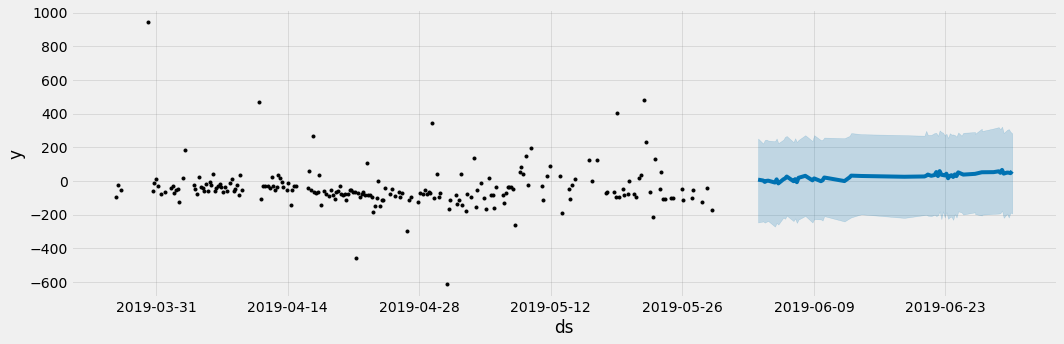

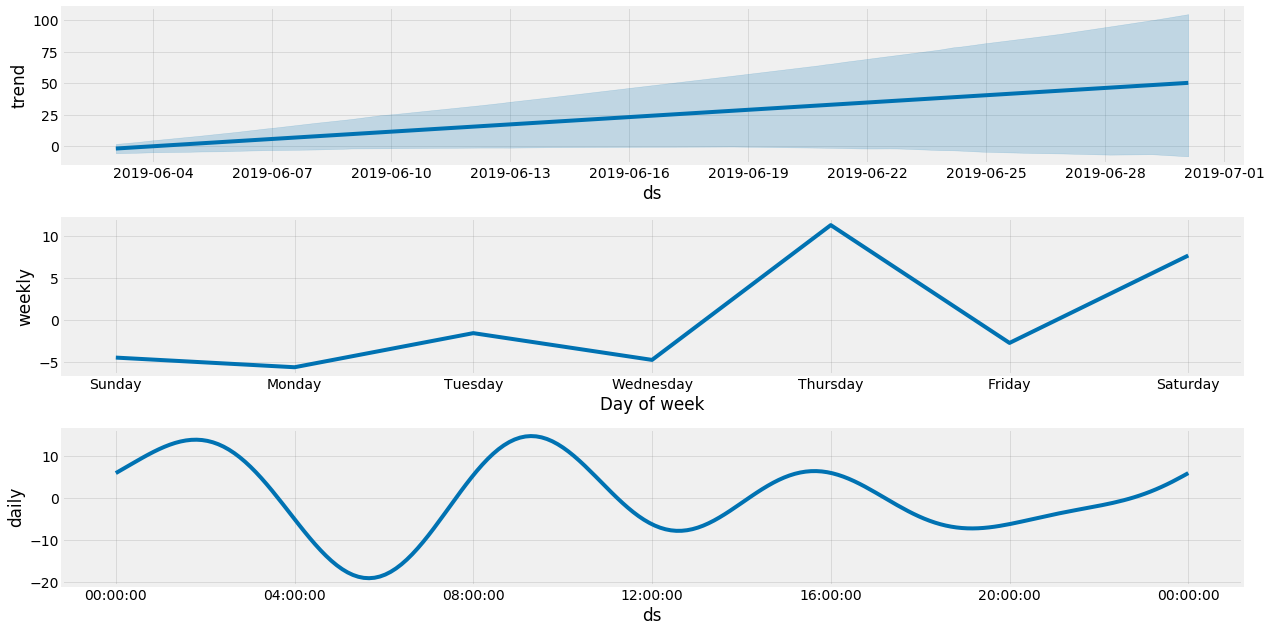

In [49]:

final_modelN = Prophet(changepoint_prior_scale=0.3,
                      seasonality_prior_scale=0.01,
                      n_changepoints= 25,
                      interval_width=0.95)

final_modelN.fit(dataframe_train_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'}))

forecast_tunedmodel_v1 = final_modelN.predict(df=dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'}))


#future_test    = final_model.make_future_dataframe(periods=14, freq='D', include_history = False) 
#forecast_test  = final_model.predict(future_test)

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_modelN.plot(forecast_tunedmodel_v1,ax=ax) #forecast_test
plt.show()

# Plot the components of the model
fig1 = final_modelN.plot_components(forecast_tunedmodel_v1)
fig1.set_figwidth(20)


### Test the performance of the model

In [50]:
mape = mean_absolute_percentage_error(dataframe_test_CH4dry['Flux'],forecast_tunedmodel_v1['yhat'])
print("MAPE",round(mape,4))

MAPE 132.7403


In [51]:
### Use Cross Validation for tuned_model 

In [54]:
#horizon = how many days are we going to make forecast 
#period  = space between 2 or more training periods (normally 0.5 * horizon)
#initial = size of training period (normally 3* horizon)

df_cv1 = cross_validation(final_modelN, initial='42 days', period='7 days', horizon = '14 days')   
df_p1 = performance_metrics(df_cv1)
#df_p1

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00


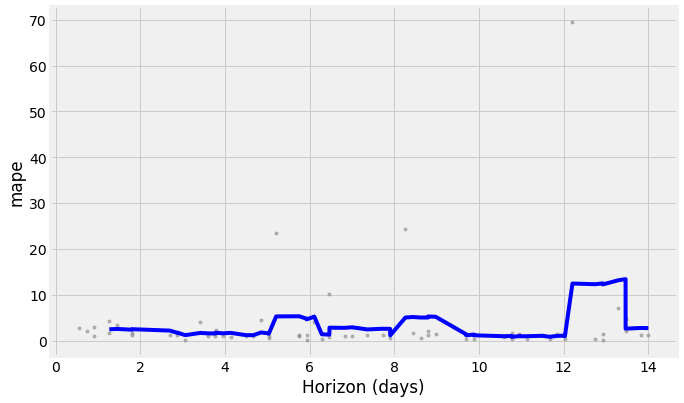

In [55]:
fig3 = plot_cross_validation_metric(df_cv1, metric='mape')

### Compare Forecast vs Actual using tuned model v1

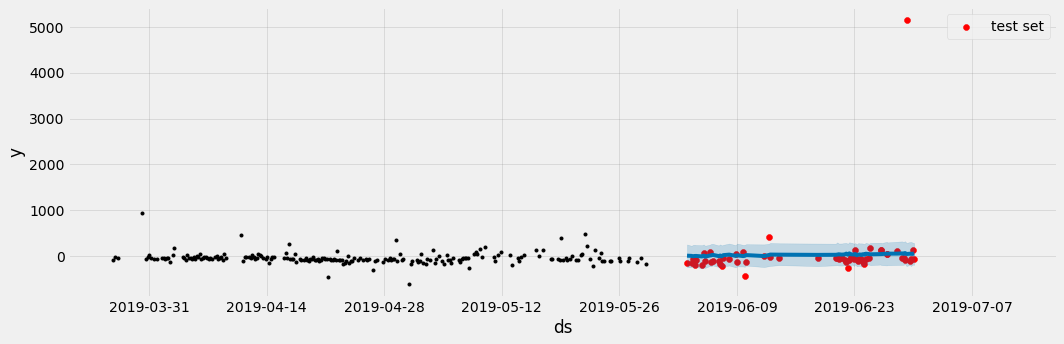

In [56]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_CH4dry.index, dataframe_test_CH4dry['Flux'], color='r', label="test set")
ax.legend()
fig = final_modelN.plot(forecast_tunedmodel_v1, ax=ax)

### Compare the gas flux in test set and in forecasted set

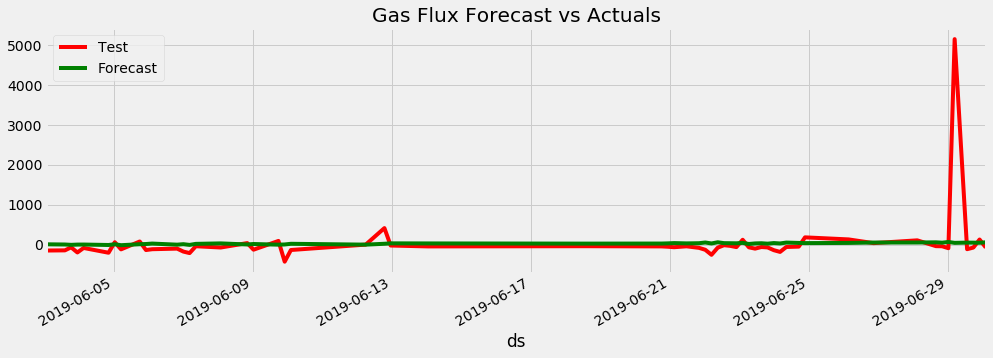

In [57]:
df1=dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'})

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df1.plot(kind='line', x='ds', y='Flux', color='red', label='Test', ax=ax)
forecast_tunedmodel_v1.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

### Forecast for next 48 hours

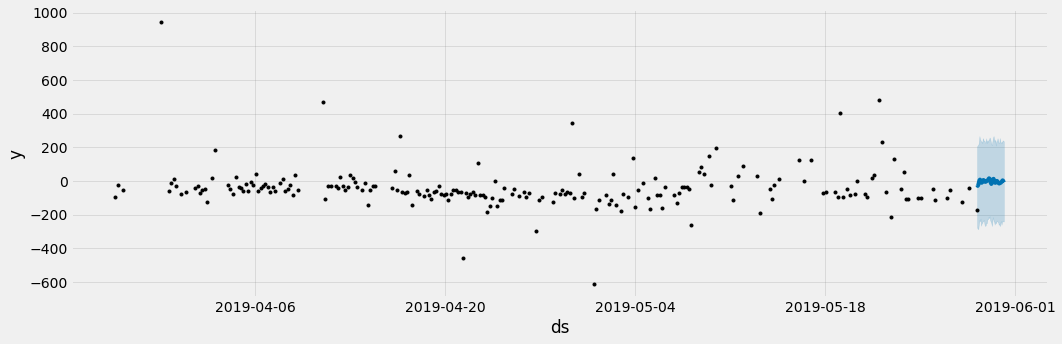

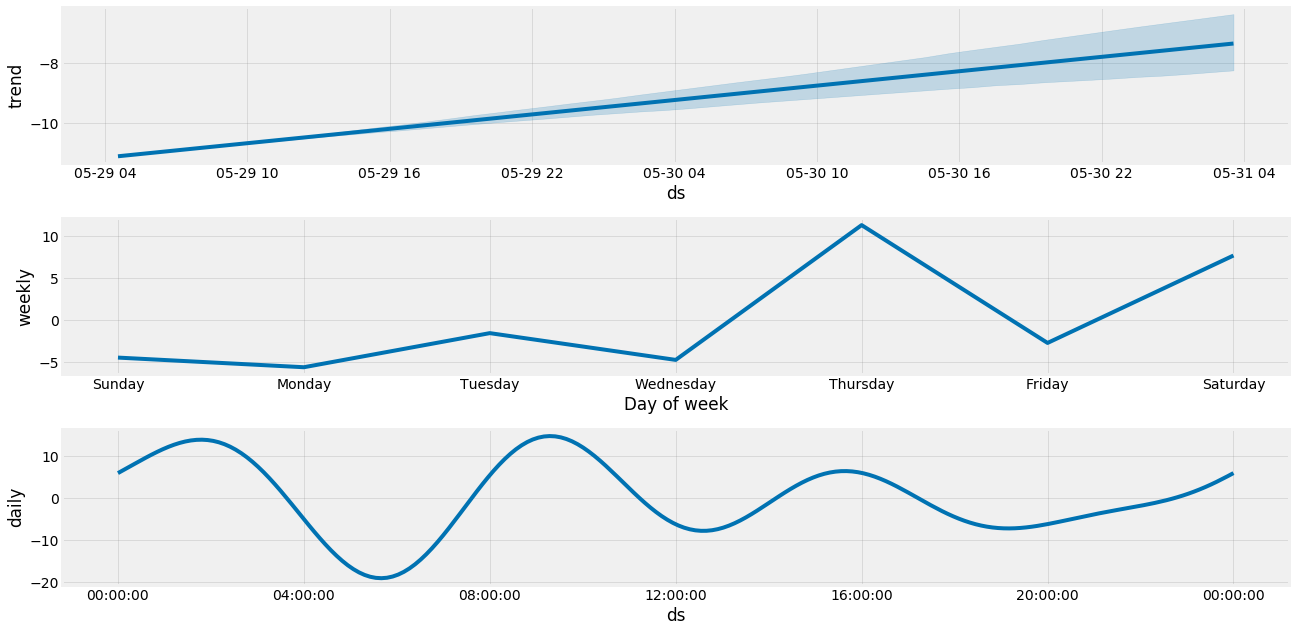

In [62]:
future_48h                   = final_modelN.make_future_dataframe(periods=48, freq='H', include_history = False) 
forecast_tunedmodel_v1_hours = final_modelN.predict(future_48h)

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_modelN.plot(forecast_tunedmodel_v1_hours,ax=ax)
plt.show()

# Plot the components of the model
fig1 = final_modelN.plot_components(forecast_tunedmodel_v1_hours)
fig1.set_figwidth(20)

### Forecast for next 2 weeks

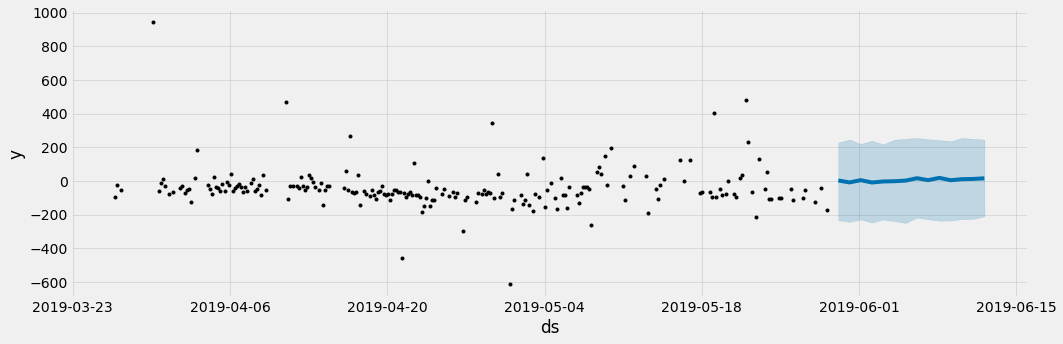

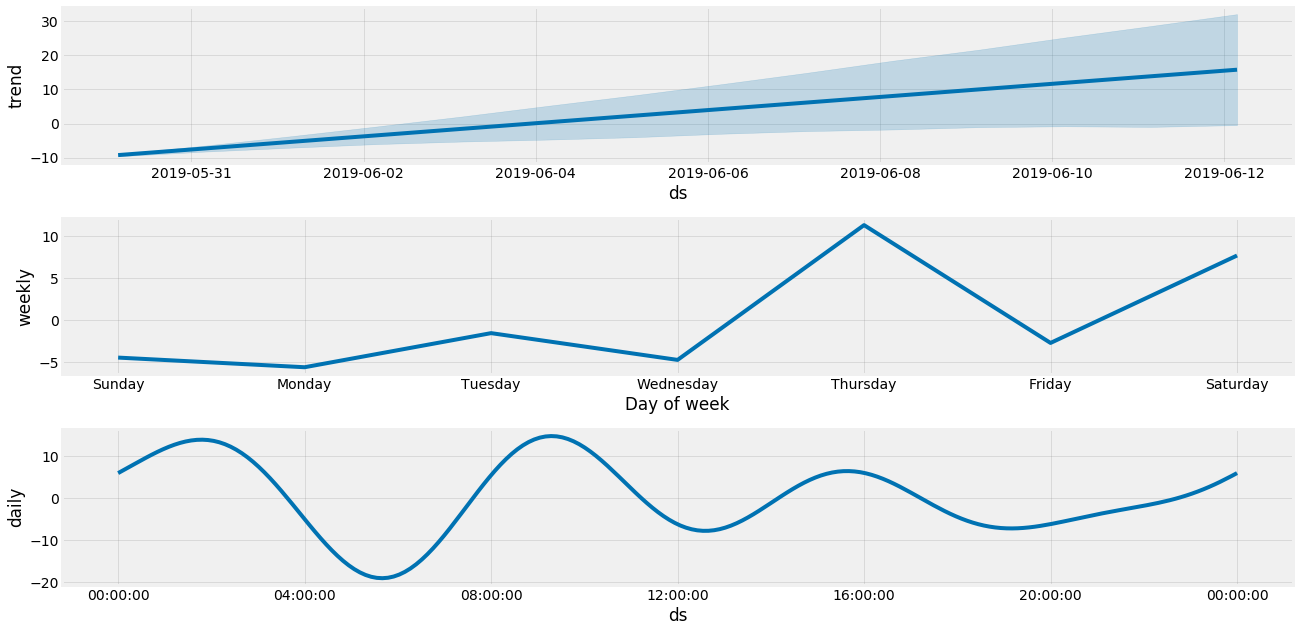

In [63]:
future_2wks                  = final_modelN.make_future_dataframe(periods=14, freq='D', include_history = False) 
forecast_tunedmodel_v1_2wks  = final_modelN.predict(future_2wks)

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_modelN.plot(forecast_tunedmodel_v1_2wks,ax=ax)
plt.show()

# Plot the components of the model
fig1 = final_modelN.plot_components(forecast_tunedmodel_v1_2wks)
fig1.set_figwidth(20)

### Save the tuned model 

In [87]:
pkl_path = "./MyProphetModels/CH4/TunedModel_v1_CH4.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(final_modelN, f)
    
# save the dataframe
forecast_tunedmodel_v1_hours.to_pickle("./MyProphetModels/CH4/forecast_tunedmodel_v1_hours.pkl")
forecast_tunedmodel_v1_2wks.to_pickle("./MyProphetModels/CH4/forecast_tunedmodel_v1_2wks.pkl")
print("*** Data Saved ***")

# To read the Prophet model object
#with open(pkl_path, 'rb') as f:
#    m = pickle.load(f)

#fcast = pd.read_pickle("path/to/data/forecast.pkl")

*** Data Saved ***


In [ ]:
### Hide code for printing/visualising purposes

In [73]:
#
#from IPython.display import HTML

#HTML('''<script>
#code_show=true; 
#function code_toggle() {
# if (code_show){
# $('div.input').hide();
# } else {
# $('div.input').show();
# }
# code_show = !code_show
#} 
#$( document ).ready(code_toggle);
#</script>
#<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


### Using a second approach - different combinations of parameters + newer parameters

In [73]:
#specify a cap and floor for limiting the forecast within these values

df = dataframe_train_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})              
df['cap']   = 5000
df['floor'] = -2000

In [74]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())  #take different combinations of the values e.g. 0.005, 0.8, 0.1, multiplicative, linear, 1
    params     = []
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m6 = Prophet(**param_dict)
    #m.add_country_holidays(country_name='US')
    m6.fit(history_df)    
    df_cv = cross_validation(m6, initial='42 days', period='7 days', horizon = '14 days') #parallel="processes" Not available yet in current release    
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

param_grid = {  
                'changepoint_prior_scale': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 5, 10.0],
                #'n_changepoints': [25,75,100],
                #'holidays_prior_scale':[0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                'growth': ['linear', 'logistic']
                #'yearly_seasonality': [5, 10, 20]
                #'daily_seasonality' : [1, 3, 5]
             }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []
rmses   = []  # Store the RMSEs for each params here

params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df, metrics, param_dict)
    results.append(cv_df)
    rmses.append(cv_df['rmse'].values[0])
    
results_df1 = pd.concat(results).reset_index(drop=True)
best_param = results_df1.loc[results_df1['mape'] == min(results_df1['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df1.to_csv("HyperParameterTuning_CH4Model_tuning_121020")

#results_df1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-


 The best param combination is {'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'growth': 'linear'}


NameError: name 'results_df' is not defined

In [267]:
results_df1.to_csv('HyperParameter_Tuning_CH4Results_mTv1.csv')

In [268]:
best_param = results_df1.loc[results_df1['mape'] == min(results_df1['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')


 The best param combination is {'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'growth': 'linear'}


### Create final model mT_v1 with the actual parameter combination

In [80]:
#The best param combination is {'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'growth': 'linear'}
mT_v1N = Prophet(
    changepoint_prior_scale=0.2,
    changepoint_range=0.9,
    seasonality_prior_scale=1.0,
    seasonality_mode='multiplicative',
    growth='linear' 
)
mT_v1N.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Run the finalised model mT_v1 with the actual parameter combination on Test data set

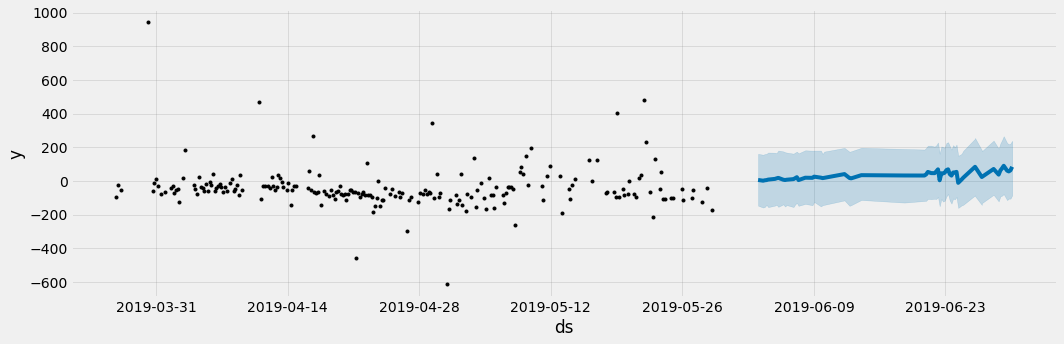

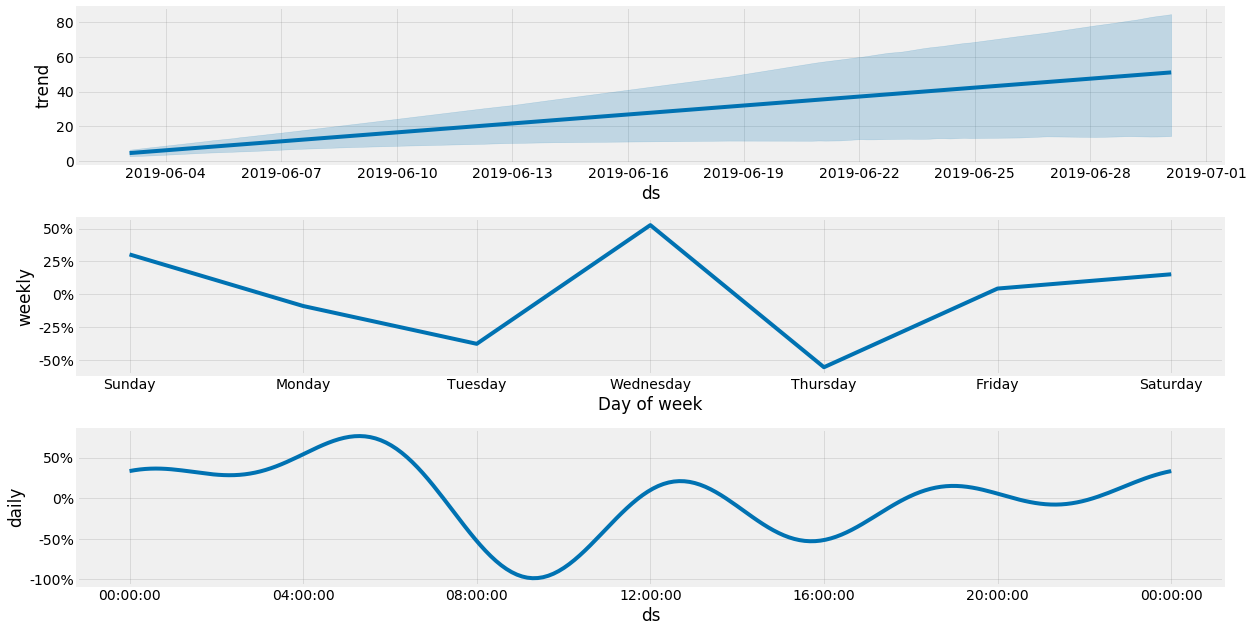

In [88]:
forecast_mT_v1 = mT_v1N.predict(dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'}))

#future_test    = final_model.make_future_dataframe(periods=14, freq='D', include_history = False) 
#forecast_test  = final_model.predict(future_test)

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = mT_v1N.plot(forecast_mT_v1,ax=ax) #forecast_test
plt.show()

# Plot the components of the model
fig1 = mT_v1N.plot_components(forecast_mT_v1)
fig1.set_figwidth(20)

### Check the performance of the tuned model mT_v1

In [82]:
mape = mean_absolute_percentage_error(dataframe_test_CH4dry['Flux'],forecast_mT_v1['yhat'])
print("MAPE",round(mape,4))

MAPE 416.5852


In [83]:
#mse = sklearn.metrics.mean_squared_error(dataframe_test_CH4dry,forecast_mT_v1)

#rmse = math.sqrt(mse)

#print(rmse)

### Compare Forecast vs Actual using Tuned Model mT_v1

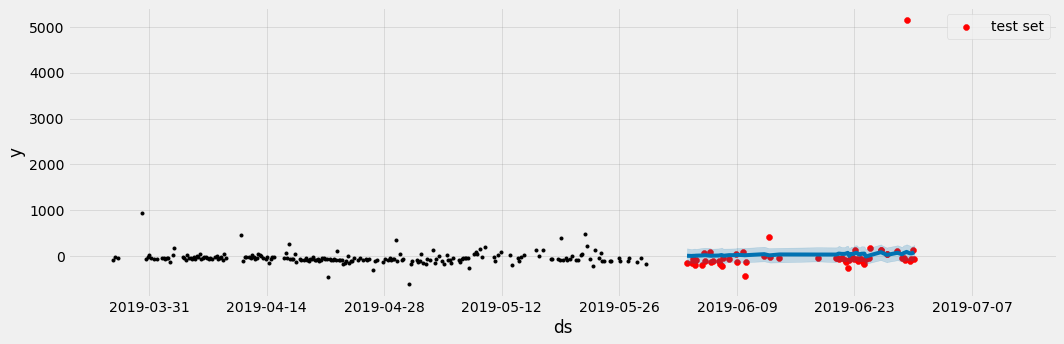

In [85]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_CH4dry.index, dataframe_test_CH4dry['Flux'], color='r', label="test set")
ax.legend()
fig = mT_v1N.plot(forecast_mT_v1, ax=ax)

### Compare the gas flux in test set and in forecasted set

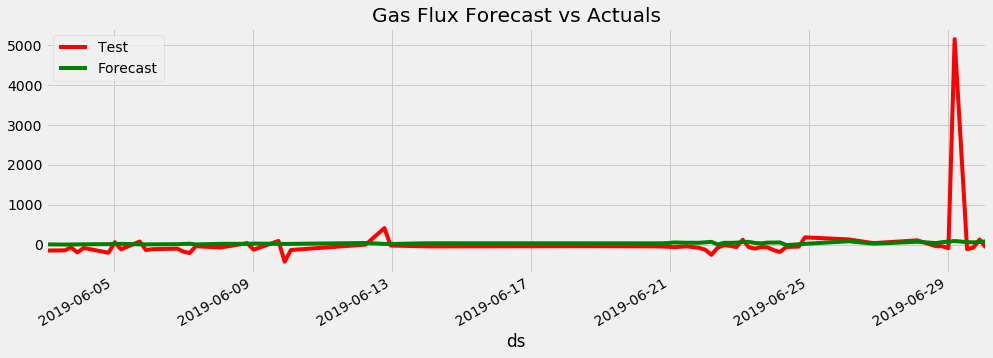

In [86]:
df1=dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'})

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df1.plot(kind='line', x='ds', y='Flux', color='red', label='Test', ax=ax)
forecast_mT_v1.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

### Cross Validation of the tuned model mT_v1

In [308]:
#horizon = how many days are we going to make forecast 
#period  = space between 2 or more training periods (normally 0.5 * horizon)
#initial = size of training period (normally 3* horizon)

df_cv2 = cross_validation(mT_v1, initial='42 days', period='7 days', horizon = '14 days')   
df_p2 = performance_metrics(df_cv2)
df_p2 

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00


horizon           mse        rmse         mae      mape  coverage
0  1 days 06:20:00   18579.700095  136.307374  124.197299  2.011038  0.500000
1  1 days 10:38:00   16160.754382  127.124956  110.280867  1.910481  0.500000
2  1 days 19:09:00   14676.706409  121.147457  104.855381  1.772143  0.666667
3  1 days 19:15:00   30702.086874  175.220110  139.578424  1.882639  0.500000
4  2 days 16:41:00   26536.020882  162.898806  123.398155  1.329024  0.666667
5  2 days 20:59:00   27602.337004  166.139511  135.984613  1.325036  0.666667
6  2 days 21:04:00   26406.578023  162.501009  131.786510  1.899453  0.833333
7  3 days 01:23:00   26087.182354  161.515270  126.108855  1.595309  0.833333
8  3 days 09:59:00   26201.358785  161.868338  126.577195  2.085607  0.833333
9  3 days 14:12:00   8531.036719   92.363611   83.831948   2.002314  1.000000
10 3 days 18:31:00   9637.436091   98.170444   89.519702   2.017725  1.000000
11 3 days 18:36:00   16078.399443  126.800629  111.547331  2.205208  0.833333
12 3 days 22:49:00   36869.599031  192.014580  152.626804  1.614209  0.666667
13 4 days 03:08:00   39218.561587  198.036768  170.650140  1.806529  0.666667
14 4 days 11:44:00   37361.584447  193.291449  160.721166  1.358548  0.666667
15 4 days 16:02:00   37920.960162  194.733048  163.899682  1.357443  0.666667
16 4 days 20:27:00   39360.104784  198.393812  169.399926  1.985092  0.666667
17 5 days 00:39:00   33325.941527  182.553941  149.706930  1.804475  0.833333
18 5 days 00:45:00   12584.762679  112.181829  108.819257  1.761083  1.000000
19 5 days 04:57:00   10252.567883  101.254965  91.439576   3.516089  1.000000
20 5 days 17:52:00   10700.711774  103.444245  94.511500   3.486647  1.000000
21 5 days 17:58:00   9259.317852   96.225349   83.154260   3.389971  1.000000
22 5 days 22:11:00   8278.778198   90.987791   79.563999   2.783704  1.000000
23 5 days 22:16:00   6878.163156   82.934692   67.435882   2.609117  1.000000
24 6 days 02:35:00   4571.331262   67.611621   55.200082   2.894393  1.000000
25 6 days 06:48:00   4537.060176   67.357703   53.415777   0.968920  1.000000
26 6 days 11:06:00   3412.397875   58.415733   39.953052   0.798325  1.000000
27 6 days 11:11:00   4661.393836   68.274401   50.292033   1.949040  1.000000
28 6 days 19:43:00   30136.692867  173.599231  97.777733   1.873464  0.833333
29 7 days 00:01:00   34519.233876  185.793525  121.477812  1.958827  0.666667
30 7 days 08:38:00   36070.195317  189.921550  130.606948  1.847823  0.666667
31 7 days 17:15:00   45294.471114  212.824978  169.114349  1.990212  0.500000
32 7 days 21:34:00   46405.970593  215.420451  182.496731  2.089940  0.500000
33 7 days 21:38:00   55278.057547  235.112861  208.622414  1.176604  0.333333
34 8 days 06:14:00   27165.914851  164.820857  140.314755  1.072099  0.500000
35 8 days 10:29:00   23613.770785  153.667729  125.346077  1.198428  0.666667
36 8 days 14:48:00   21577.516723  146.892875  109.962222  0.971828  0.666667
37 8 days 19:06:00   16822.124480  129.700133  98.046866   1.042176  0.666667
38 8 days 19:09:00   25701.906837  160.318143  125.241943  1.270090  0.500000
39 8 days 23:25:00   20452.000993  143.010493  112.790775  1.201806  0.500000
40 9 days 16:38:00   24339.933676  156.012607  138.104639  1.408338  0.333333
41 9 days 16:41:00   23437.420026  153.092848  126.620970  1.173869  0.333333
42 9 days 20:56:00   29359.197481  171.345258  154.875481  1.431776  0.166667
43 9 days 20:59:00   25923.083755  161.006471  140.713888  1.378870  0.333333
44 10 days 14:12:00  15999.277387  126.488250  103.267595  1.095947  0.500000
45 10 days 18:29:00  13530.768260  116.321831  94.958260   1.234328  0.666667
46 10 days 18:31:00  9662.127761   98.296123   71.301009   1.008282  0.833333
47 10 days 22:47:00  17311.422607  131.572879  106.208213  1.314048  0.666667
48 10 days 22:49:00  58674.805251  242.228828  163.452330  1.216887  0.666667
49 11 days 03:08:00  57648.735131  240.101510  151.585648  1.032036  0.666667
50 11 days 11:44:00  57584.378285 

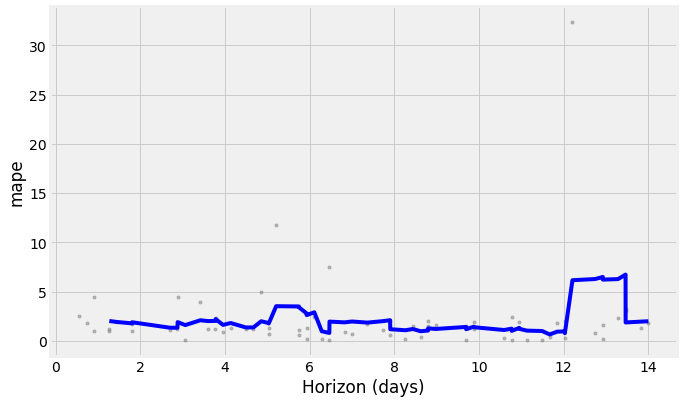

In [275]:
fig3 = plot_cross_validation_metric(df_cv2, metric='mape')

### Run the tuned model mT_v1 with the actual parameter combination to generate forecasts on the gas flux

#### Forecast next 30 days using model mT_v1

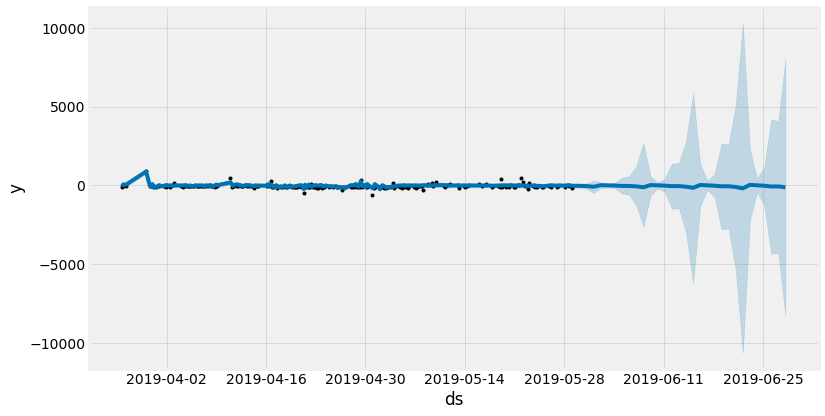

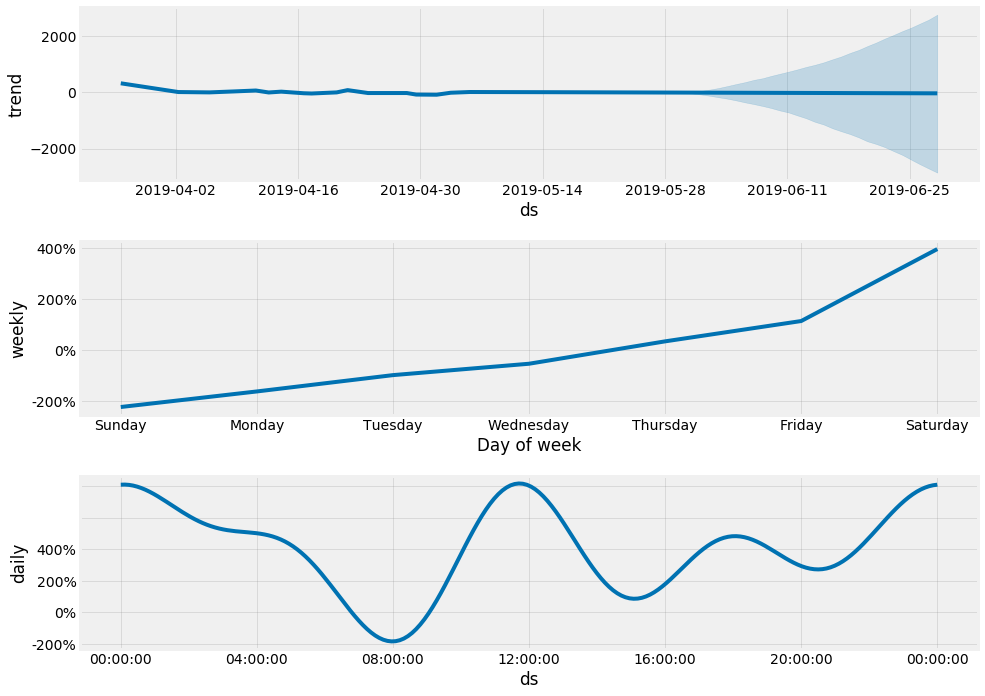

In [210]:
#futureT              = mT_v1.make_future_dataframe(periods=30, freq='D', include_history = True)   #include_history = False
#forecast_mT_v1_30D   = mT_v1.predict(futureT)

#fig21                = mT_v1.plot(forecast_mT_v1_30D)
#fig21.set_figwidth(12)
#fig21.set_figheight(6)

##Save boxplot as a file
##output file name
#plot_file_name="../prophetForecastPlots/Plot"+plotId+"/CH4_gasflux_Plot"+plotId+"_mTv1_model_output.png" 
## save as png
#plt.savefig(plot_file_name)


#fig22                      = mT_v1.plot_components(forecast_mT_v1_30D)
#fig22.set_figwidth(15)
#fig22.set_figheight(10)

##Save boxplot as a file
##output file name
#plot_file_name="../prophetForecastPlots/Plot"+plotId+"/CH4_gasflux_Plot"+plotId+"_mTv1_components_output.png" 
## save as png
#plt.savefig(plot_file_name)

#### Compare forecasted (30 days) using tuned model mT_v1 with test data set

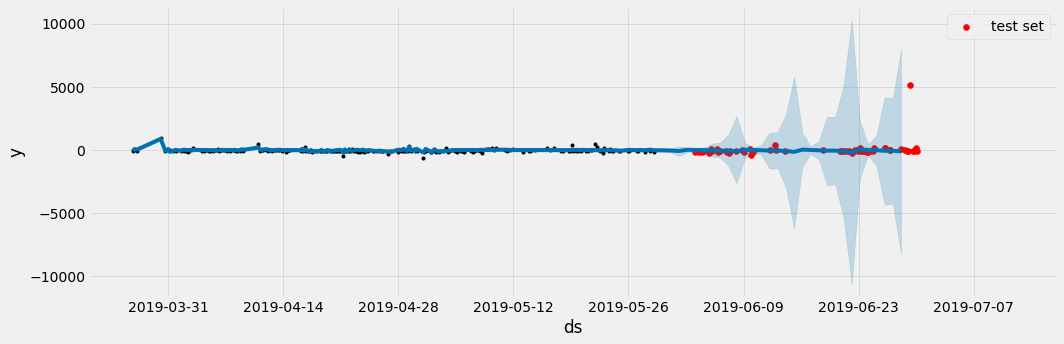

In [211]:
## Plot the forecast with the actuals
#f, ax = plt.subplots(1)
#f.set_figheight(5)
#f.set_figwidth(15)
#ax.scatter(dataframe_test_CH4dry.index, dataframe_test_CH4dry['Flux'], color='r', label="test set")
#ax.legend()
#fig = mT_v1.plot(forecast_mT_v1_30D, ax=ax)

#### Forecast for next 48 hours

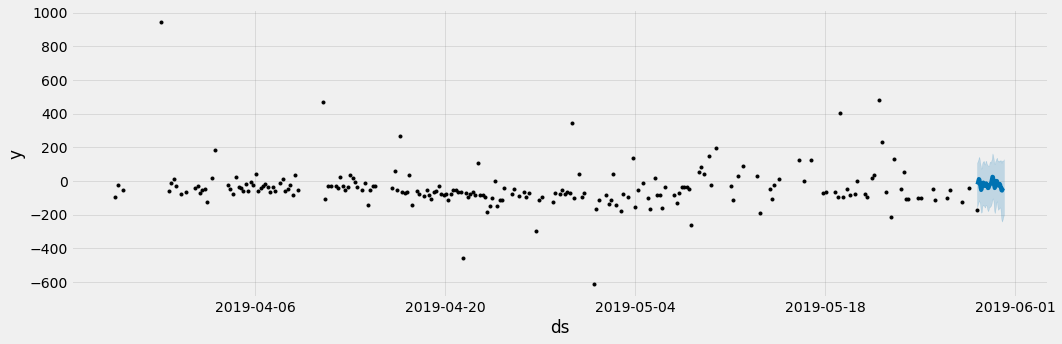

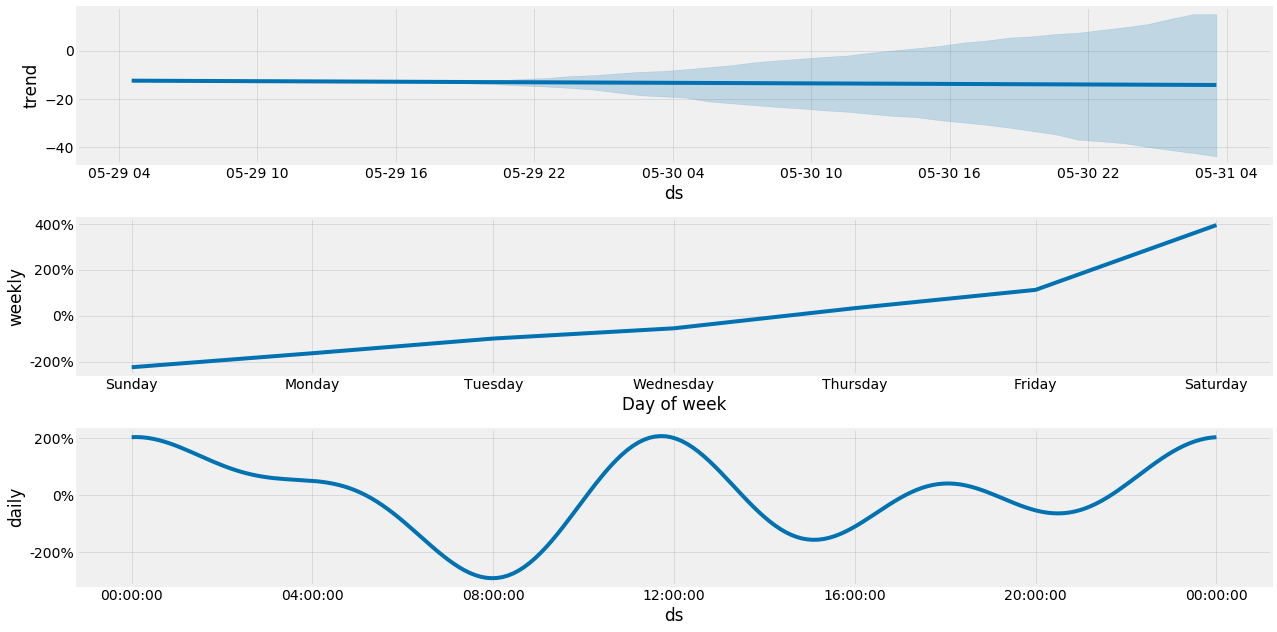

In [212]:
#future_48hT             = mT_v1.make_future_dataframe(periods=48, freq='H', include_history = False) 
#forecast_mT_v1_48hoursT = mT_v1.predict(future_48hT)

## Plot the forecast
#f, ax = plt.subplots(1)
#f.set_figheight(5)
#f.set_figwidth(15)
#fig = mT_v1.plot(forecast_mT_v1_48hoursT,ax=ax)
#plt.show()

## Plot the components of the model
#fig1 = mT_v1.plot_components(forecast_mT_v1_48hoursT)
#fig1.set_figwidth(20)

#### Forecast for next 2 weeks

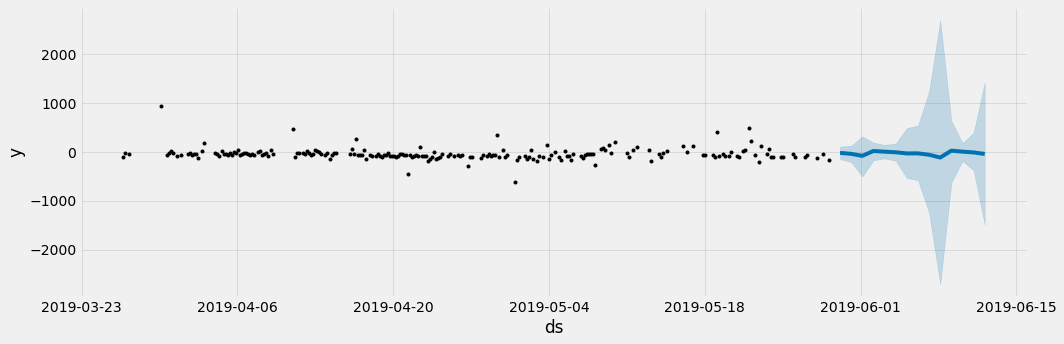

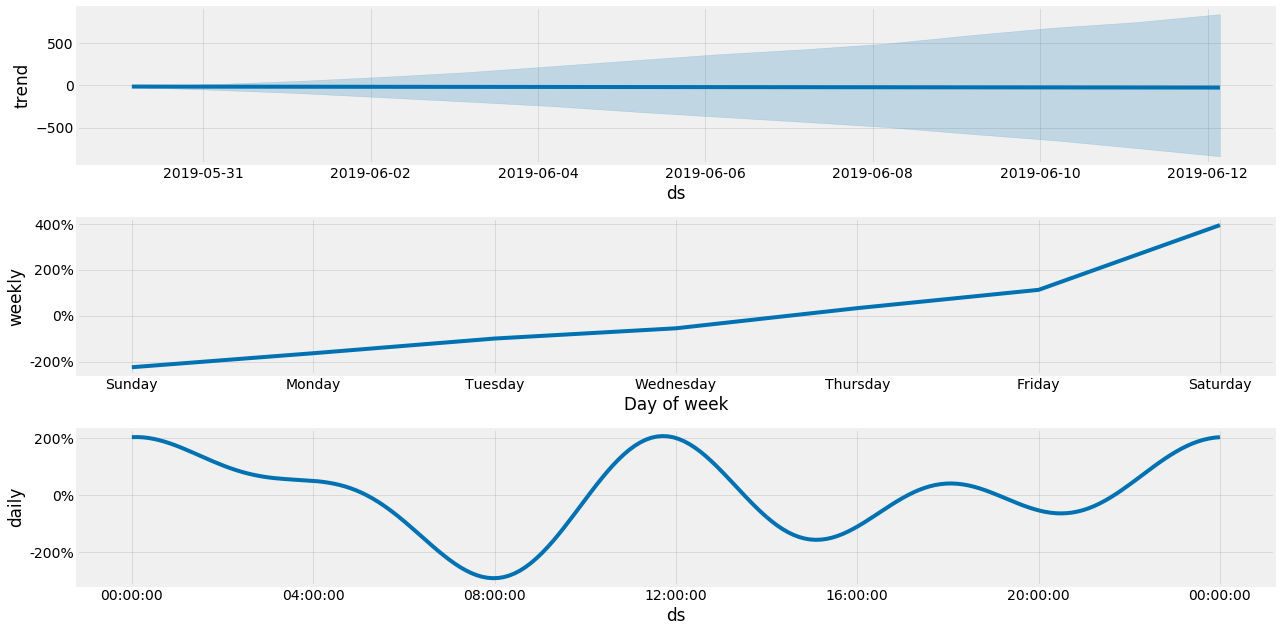

In [213]:
#future_2W            = mT_v1.make_future_dataframe(periods=14, freq='D', include_history = False) 
#forecast_mT_v1_2Wks  = mT_v1.predict(future_2W)

## Plot the forecast
#f, ax = plt.subplots(1)
#f.set_figheight(5)
#f.set_figwidth(15)
#fig = mT_v1.plot(forecast_mT_v1_2Wks,ax=ax)
#plt.show()

## Plot the components of the model
#fig1 = mT_v1.plot_components(forecast_mT_v1_2Wks)
#fig1.set_figwidth(20)

#### Forecast for next 2 months

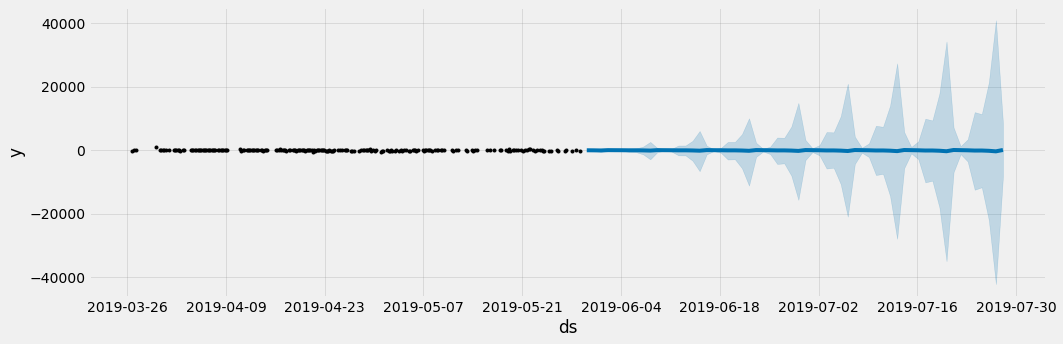

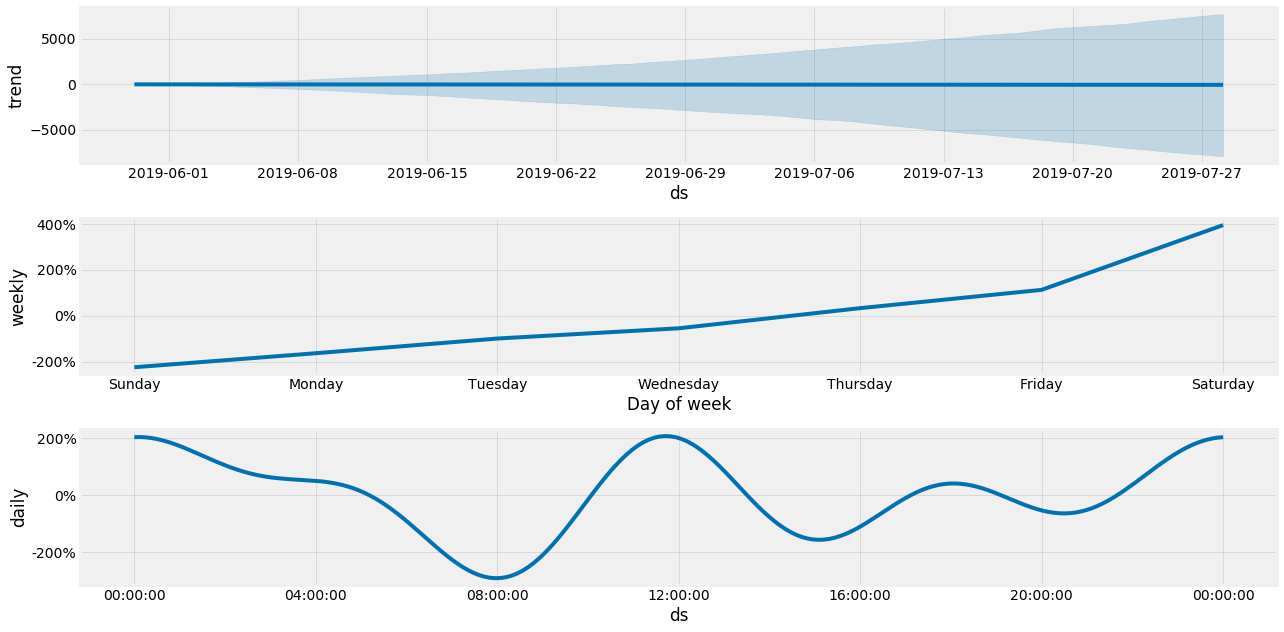

In [214]:
#future_2M          = mT_v1.make_future_dataframe(periods=30*2, freq='D', include_history = False) 
#forecast_mT_v1_2M  = mT_v1.predict(future_2M)

## Plot the forecast
#f, ax = plt.subplots(1)
#f.set_figheight(5)
#f.set_figwidth(15)
#fig = mT_v1.plot(forecast_mT_v1_2M,ax=ax)
#plt.show()

## Plot the components of the model
#fig1 = mT_v1.plot_components(forecast_mT_v1_2M)
#fig1.set_figwidth(20)

#### Compare actual vs forecast (2 weeks) using tuned model mT_v1

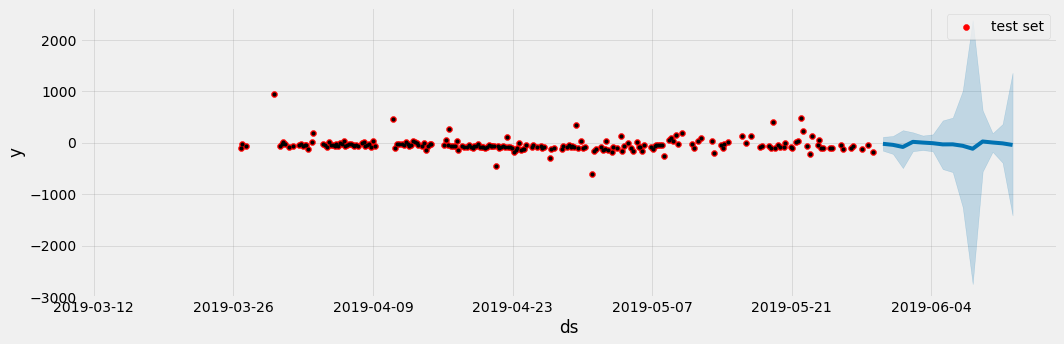

In [121]:
#### df = df_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})

## Plot the forecast with the actuals
#f1, ax = plt.subplots(1)
#f1.set_figheight(5)
#f1.set_figwidth(15)
#ax.scatter(df.ds, df['y'], color='r', label="test set")
#ax.legend()

#fig2 = mT_v1.plot(forecast_tuned_model_v2_2Wks, ax=ax)

### Save the Model mT_v1

In [77]:
pkl_path = "./MyProphetModels/CH4/TunedModel_v1_CH4.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(mT_v1, f)
    
# save the dataframe
forecast_mT_v1.to_pickle("./MyProphetModels/CH4/forecast_mT_v1.pkl")
#forecast_mT_v1_30D.to_pickle("./MyProphetModels/CH4/forecast_mT_v1_30D.pkl")
#forecast_mT_v1_48hoursT.to_pickle("./MyProphetModels/CH4/forecast_mT_v1_48hoursT.pkl")
#forecast_mT_v1_2Wks.to_pickle("./MyProphetModels/CH4/forecast_mT_v1_2Wks.pkl")
#forecast_mT_v1_2M.to_pickle("./MyProphetModels/CH4/forecast_mT_v1_2M.pkl")


print("*** Data Saved ***")

*** Data Saved ***


## Using a second approach - try a different combination of parameters 
- add seasonality

In [276]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())  #take different combinations of the values e.g. 0.005, 0.8, 0.1, multiplicative, linear, 1
    params     = []
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m5 = Prophet(**param_dict)
    #m.add_country_holidays(country_name='US')
    m5.fit(history_df)    
    df_cv = cross_validation(m5, initial='42 days', period='7 days', horizon = '14 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

param_grid = {  
                'changepoint_prior_scale': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 10.0],
                #'holidays_prior_scale':[0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                'growth': ['linear', 'logistic'],
                #'yearly_seasonality': [5, 10, 20]
                'weekly_seasonality' : [1, 3, 5]
             }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []


params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df, metrics, param_dict)
    results.append(cv_df)
    
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['mape'] == min(results_df['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
#results_df.to_csv("HyperParameterTuning_CH4Modelv2")
results_df

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-


 The best param combination is {'changepoint_prior_scale': 0.3, 'changepoint_range': 0.9, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'growth': 'linear', 'weekly_seasonality': 1}


horizon     rmse     mape  \
0   7 days 18:25:52.500000  160.459  5.44349   
1   7 days 18:25:52.500000  161.541  5.37834   
2   7 days 18:25:52.500000  158.436  4.77956   
3   7 days 18:25:52.500000  160.789  5.48739   
4   7 days 18:25:52.500000  158.174  5.41192   
5   7 days 18:25:52.500000  159.735  5.56581   
6   7 days 18:25:52.500000  159.015  4.7832    
7   7 days 18:25:52.500000  163.612  4.00471   
8   7 days 18:25:52.500000  163.96   3.85443   
9   7 days 18:25:52.500000  157.094  4.41808   
10  7 days 18:25:52.500000  161.141  3.68085   
11  7 days 18:25:52.500000  162.071  3.53091   
12  7 days 18:25:52.500000  162.342  5.35342   
13  7 days 18:25:52.500000  179.304  2.80019   
14  7 days 18:25:52.500000  183.735  3.344     
15  7 days 18:25:52.500000  161.079  5.51074   
16  7 days 18:25:52.500000  158.049  5.3882    
17  7 days 18:25:52.500000  161.633  5.69001   
18  7 days 18:25:52.500000  158.495  4.72155   
19  7 days 18:25:52.500000  163.97   4.01511   
20  7 days 18:25:52.500000  163.709  3.77693   
21  7 days 18:25:52.500000  156.768  4.41262   
22  7 days 18:25:52.500000  160.811  3.63334   
23  7 days 18:25:52.500000  162.832  3.58443   
24  7 days 18:25:52.500000  165.251  4.71408   
25  7 days 18:25:52.500000  177.464  3.02068   
26  7 days 18:25:52.500000  176.449  2.64523   
27  7 days 18:25:52.500000  161.188  5.52615   
28  7 days 18:25:52.500000  158.515  5.43521   
29  7 days 18:25:52.500000  162.098  5.73386   
30  7 days 18:25:52.500000  159.05   4.77329   
31  7 days 18:25:52.500000  163.526  3.96735   
32  7 days 18:25:52.500000  163.879  3.79776   
33  7 days 18:25:52.500000  156.905  4.40678   
34  7 days 18:25:52.500000  160.981  3.6509    
35  7 days 18:25:52.500000  162.864  3.57895   
36  7 days 18:25:52.500000  156.535  5.27255   
37  7 days 18:25:52.500000  157.825  5.24069   
38  7 days 18:25:52.500000  158.097  5.21457   
39  7 days 18:25:52.500000  160.74   5.51981   
40  7 days 18:25:52.500000  157.649  5.38443   
41  7 days 18:25:52.500000  161.773  5.72075   
42  7 days 18:25:52.500000  154.302  4.51341   
43  7 days 18:25:52.500000  158.614  3.68744   
44  7 days 18:25:52.500000  160.564  3.63891   
45  7 days 18:25:52.500000  156.643  4.42631   
46  7 days 18:25:52.500000  160.036  3.57228   
47  7 days 18:25:52.500000  162.388  3.55791   
48  7 days 18:25:52.500000  160.889  4.41829   
49  7 days 18:25:52.500000  162.296  4.20568   
50  7 days 18:25:52.500000  183.931  2.73295   
51  7 days 18:25:52.500000  159.559  5.4273    
52  7 days 18:25:52.500000  158.426  5.45819   
53  7 days 18:25:52.500000  161.948  5.70904   
54  7 days 18:25:52.500000  154.285  4.49259   
55  7 days 18:25:52.500000  159.669  3.75722   
56  7 days 18:25:52.500000  159.837  3.51374   
57  7 days 18:25:52.500000  157.05   4.50191   
58  7 days 18:25:52.500000  159.967  3.61021   
59  7 days 18:25:52.500000  162.57   3.60884   
60  7 days 18:25:52.500000  156.588  5.25171   
61  7 days 18:25:52.500000  166.788  4.56813   
62  7 days 18:25:52.500000  180.922  2.66915   
63  7 days 18:25:52.500000  160.192  5.46016   
64  7 days 18:25:52.500000  158.353  5.43583   
65  7 days 18:25:52.500000  162.426  5.76282   
66  7 days 18:25:52.500000  154.221  4.47984   
67  7 days 18:25:52.500000  159.729  3.77531   
68  7 days 18:25:52.500000  160.042  3.5374    
69  7 days 18:25:52.500000  157.977  4.50614   
70  7 days 18:25:52.500000  160.212  3.61007   
71  7 days 18:25:52.500000  162.298  3.5472    
72  7 days 18:25:52.500000  155.671  4.38585   
73  7 days 18:25:52.500000  156.752  4.17885   
74  7 days 18:25:52.500000  156.067  4.06166   
75  7 days 18:25:52.500000  152.305  4.17904   
76  7 days 18:25:52.500000  148.509  4.05285   
77  7 days 18:25:52.500000  149.227  4.29274   
78  7 days 18:25:52.500000  152.605  3.75736   
79  7 days 18:25:52.500000  156.647  3.3437    
80  7 days 18:25:52.500000  157.203  3.08803   
81  7 days 18:25:52.500000  149.502  3.46523   
82  7 days 18:25:52.500000  154.041

In [277]:
results_df.to_csv("HyperParameterTuning_CH4Model_mTv2")

best_param = results_df.loc[results_df['mape'] == min(results_df['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')


 The best param combination is {'changepoint_prior_scale': 0.3, 'changepoint_range': 0.9, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'growth': 'linear', 'weekly_seasonality': 1}


### Create the finalised model mT_v2 from the above combination

In [89]:
#specify a cap and floor for limiting the forecast within these values

df = dataframe_train_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})              
df['cap']   = 5000
df['floor'] = -2000

In [90]:
mT_v2 = Prophet(
    changepoint_prior_scale=0.3,
    changepoint_range=0.9,
    seasonality_prior_scale=1.0,
    seasonality_mode='multiplicative',
    growth='linear',
    weekly_seasonality= 1
)

mT_v2.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Run the finalised model mT_v2 (with the new combination set) to predict test data set

In [ ]:
#df = dataframe_train_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})  

forecast_mT_v2 = mT_v2.predict(df=dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'}))

#future_test    = final_model.make_future_dataframe(periods=14, freq='D', include_history = False) 
#forecast_test  = final_model.predict(future_test)

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = mT_v2.plot(forecast_mT_v2,ax=ax) #forecast_test

#plt.show()

## Plot the components of the model
#fig1 = mT_v2.plot_components(forecast_mT_v2)
#fig1.set_figwidth(20)

### Check the performance of the tuned model mT_v2

In [92]:
mape = mean_absolute_percentage_error(dataframe_test_CH4dry['Flux'],forecast_mT_v2['yhat'])
print("MAPE",round(mape,4))

MAPE 522.2729


In [93]:
import sklearn
import math

mse = sklearn.metrics.mean_squared_error(dataframe_test_CH4dry['Flux'],forecast_mT_v2['yhat'])

rmse = math.sqrt(mse)

print(rmse)

900.9928317833803


### Compare Forecast vs Actual using Tuned Model mT_v2

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_CH4dry.index, dataframe_test_CH4dry['Flux'], color='r', label="test set")
ax.legend()
#fig = mT_v2.plot(forecast_mT_v2, ax=ax)

#### The model does not look accurate.

### Run the finalised model mT_v2 with the new combination set to forecast next 30 days

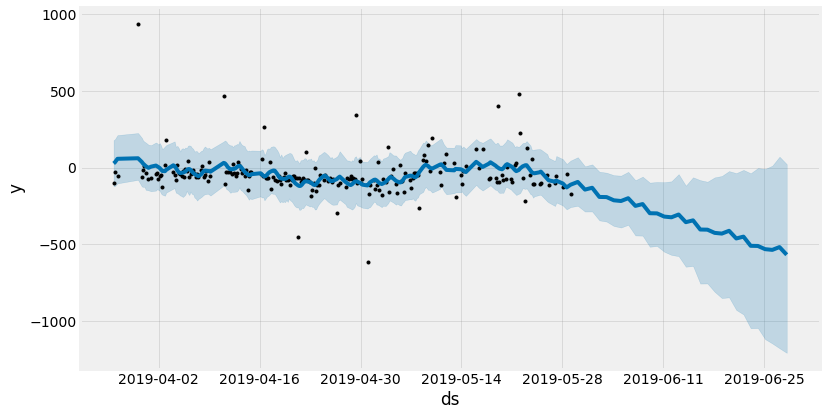

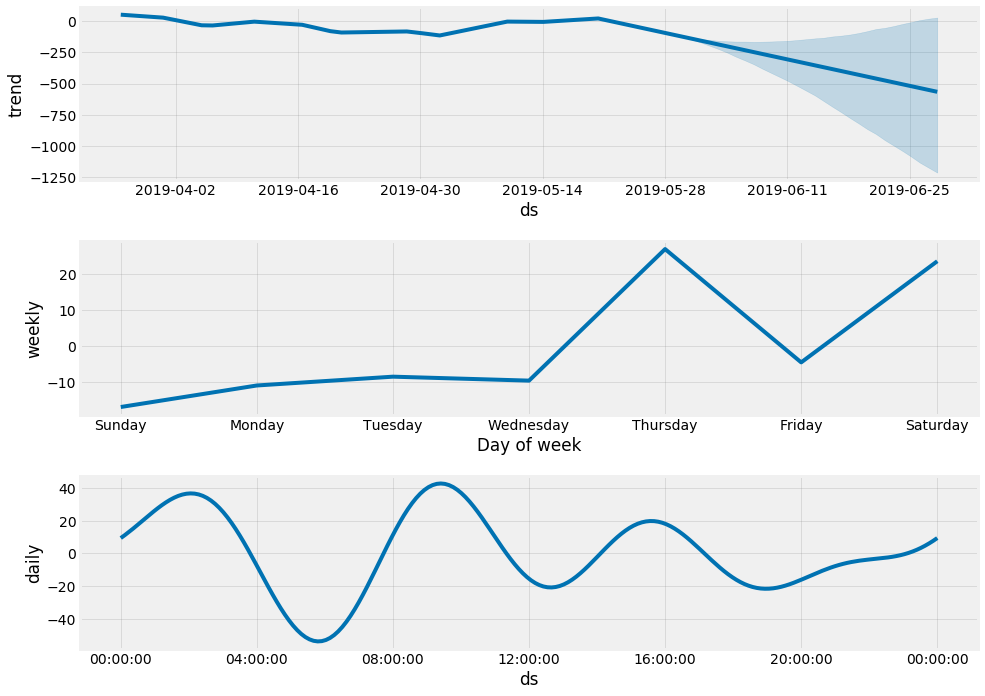

In [252]:
##mT.add_country_holidays(country_name='US')
#futureT_v2               = mT_v2.make_future_dataframe(periods=30) 

#forecast_mT_v2_30D       = mT_v2.predict(futureT_v2)

#fig21                    = mT_v2.plot(forecast_tuned_model_v2T_v2)
#fig21.set_figwidth(12)
#fig21.set_figheight(6)

##Save boxplot as a file
##output file name
#plot_file_name="../prophetForecastPlots/Plot"+plotId+"/CH4_gasflux_Plot"+plotId+"_mTv2_model_output.png" 
## save as png
#plt.savefig(plot_file_name)


#fig22                      = mT_v2.plot_components(forecast_tuned_model_v2T_v2)
#fig22.set_figwidth(15)
#fig22.set_figheight(10)

##Save boxplot as a file
##output file name
#plot_file_name="../prophetForecastPlots/Plot"+plotId+"/CH4_gasflux_Plot"+plotId+"_mTv2_components_output.png" 
## save as png
#plt.savefig(plot_file_name)

### Save the model mT_v2

In [97]:
pkl_path = "./MyProphetModels/CH4/TunedModel_mT_v2_CH4.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(mT_v2, f)
    
## save the dataframe
#forecast_mT_v2_30D.to_pickle("./MyProphetModels/CH4/forecast_tuned_model_mT_v2_30D.pkl")
#forecast_tuned_model_v2_hoursT.to_pickle("./MyProphetModels/CH4/forecast_tuned_model_v2_hoursT.pkl")
#forecast_tuned_model_v2_2Wks.to_pickle("./MyProphetModels/CH4/forecast_tuned_model_v2_2Wks.pkl")
#forecast_tuned_model_v2_2M.to_pickle("./MyProphetModels/CH4/forecast_tuned_model_v2_2M.pkl")


#print("*** Data Saved ***")

# To read the Prophet model object
#with open(pkl_path, 'rb') as f:
#    m = pickle.load(f)

#fcast = pd.read_pickle("path/to/data/forecast.pkl")

### Try a third combination of parameters -  mT_v3

In [285]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())  #take different combinations of the values e.g. 0.005, 0.8, 0.1, multiplicative, linear, 1
    params     = []
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m6 = Prophet(**param_dict)
    #m.add_country_holidays(country_name='US')
    m6.fit(history_df)    
    df_cv = cross_validation(m6, initial='42 days', period='7 days', horizon = '14 days') #parallel="processes" Not available yet in current release    
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

param_grid = {  
                'changepoint_prior_scale': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 10.0],
                #'n_changepoints': [25,75,100],
                #'holidays_prior_scale':[0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                'growth': ['linear', 'logistic'],
                #'yearly_seasonality': [5, 10, 20]
                'daily_seasonality' : [1, 3, 5]
             }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []
#rmses   = []  # Store the RMSEs for each params here

params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df, metrics, param_dict)
    results.append(cv_df)
    rmses.append(cv_df['rmse'].values[0])
    
results_df3 = pd.concat(results).reset_index(drop=True)
best_param = results_df3.loc[results_df3['mape'] == min(results_df3['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
#results_df.to_csv("HyperParameterTuning_CH4Modelv2")

#results_df3

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-


 The best param combination is {'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'growth': 'linear', 'daily_seasonality': 1}


horizon     rmse     mape  \
0   7 days 18:25:52.500000  160.949  5.4767    
1   7 days 18:25:52.500000  161.808  5.47003   
2   7 days 18:25:52.500000  160.037  5.00407   
3   7 days 18:25:52.500000  156.32   5.29934   
4   7 days 18:25:52.500000  156.701  5.29385   
5   7 days 18:25:52.500000  161.502  5.65026   
6   7 days 18:25:52.500000  164.307  4.93954   
7   7 days 18:25:52.500000  163.7    4.56959   
8   7 days 18:25:52.500000  165.741  4.32032   
9   7 days 18:25:52.500000  162.066  4.68565   
10  7 days 18:25:52.500000  161.878  4.31531   
11  7 days 18:25:52.500000  165.197  4.13488   
12  7 days 18:25:52.500000  164.32   3.52041   
13  7 days 18:25:52.500000  176.561  2.63501   
14  7 days 18:25:52.500000  182.206  2.02557   
15  7 days 18:25:52.500000  156.182  5.29769   
16  7 days 18:25:52.500000  156.2    5.27551   
17  7 days 18:25:52.500000  161.616  5.63986   
18  7 days 18:25:52.500000  164.012  4.89615   
19  7 days 18:25:52.500000  163.368  4.52048   
20  7 days 18:25:52.500000  165.909  4.28711   
21  7 days 18:25:52.500000  163.263  4.80395   
22  7 days 18:25:52.500000  161.247  4.27382   
23  7 days 18:25:52.500000  164.808  4.08206   
24  7 days 18:25:52.500000  175.663  3.57521   
25  7 days 18:25:52.500000  178.429  2.28419   
26  7 days 18:25:52.500000  185.288  2.78749   
27  7 days 18:25:52.500000  156.368  5.3127    
28  7 days 18:25:52.500000  155.79   5.23793   
29  7 days 18:25:52.500000  161.318  5.61701   
30  7 days 18:25:52.500000  165.194  5.00602   
31  7 days 18:25:52.500000  163.27   4.49821   
32  7 days 18:25:52.500000  166.015  4.30395   
33  7 days 18:25:52.500000  162.827  4.75489   
34  7 days 18:25:52.500000  161.382  4.3006    
35  7 days 18:25:52.500000  164.211  4.03248   
36  7 days 18:25:52.500000  157.153  5.31071   
37  7 days 18:25:52.500000  157.231  5.27401   
38  7 days 18:25:52.500000  158.229  5.2863    
39  7 days 18:25:52.500000  157.183  5.37239   
40  7 days 18:25:52.500000  156.258  5.24588   
41  7 days 18:25:52.500000  160.71   5.59998   
42  7 days 18:25:52.500000  161.367  4.78802   
43  7 days 18:25:52.500000  160.468  4.42436   
44  7 days 18:25:52.500000  161.601  4.04532   
45  7 days 18:25:52.500000  162.058  4.70286   
46  7 days 18:25:52.500000  161.309  4.2604    
47  7 days 18:25:52.500000  165.391  4.13489   
48  7 days 18:25:52.500000  167.373  4.7618    
49  7 days 18:25:52.500000  167.849  4.27033   
50  7 days 18:25:52.500000  171.018  4.42526   
51  7 days 18:25:52.500000  156.922  5.35748   
52  7 days 18:25:52.500000  156.361  5.29759   
53  7 days 18:25:52.500000  161.805  5.66724   
54  7 days 18:25:52.500000  161.042  4.74008   
55  7 days 18:25:52.500000  160.002  4.32549   
56  7 days 18:25:52.500000  163.229  4.15648   
57  7 days 18:25:52.500000  161.912  4.69011   
58  7 days 18:25:52.500000  161.627  4.29905   
59  7 days 18:25:52.500000  164.623  4.09614   
60  7 days 18:25:52.500000  166.08   4.65698   
61  7 days 18:25:52.500000  171.399  4.55584   
62  7 days 18:25:52.500000  169.916  4.34916   
63  7 days 18:25:52.500000  157.444  5.38978   
64  7 days 18:25:52.500000  156.51   5.31307   
65  7 days 18:25:52.500000  161.706  5.66096   
66  7 days 18:25:52.500000  160.961  4.7355    
67  7 days 18:25:52.500000  160.074  4.34027   
68  7 days 18:25:52.500000  163.117  4.14044   
69  7 days 18:25:52.500000  161.555  4.69256   
70  7 days 18:25:52.500000  161.386  4.26938   
71  7 days 18:25:52.500000  163.914  4.02916   
72  7 days 18:25:52.500000  154.758  4.40742   
73  7 days 18:25:52.500000  156.89   4.2822    
74  7 days 18:25:52.500000  158.358  4.28363   
75  7 days 18:25:52.500000  146.42   4.02986   
76  7 days 18:25:52.500000  145.45   3.82707   
77  7 days 18:25:52.500000  150.533  4.28149   
78  7 days 18:25:52.500000  157.246  4.0148    
79  7 days 18:25:52.500000  156.411  3.47895   
80  7 days 18:25:52.500000  159.579  3.4311    
81  7 days 18:25:52.500000  152.63   3.3546    
82  7 days 18:25:52.500000  151.635

In [ ]:
results_df3.to_csv("HyperParameterTuning_CH4Model_mTv3")

best_param = results_df3.loc[results_df3['mape'] == min(results_df3['mape']), ['params']]
#print(f'\n The best param combination is {best_param.values[0][0]}')

### Create the finalised model mT_v3 from the above combination

In [98]:
mT_v3 = Prophet(
    changepoint_prior_scale=0.4,
    changepoint_range=0.9,
    seasonality_prior_scale=1.0,
    #n_changepoints=25,
    seasonality_mode='multiplicative',
    growth='linear',
    daily_seasonality=1
)

mT_v3.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Run the finalised model mT_v3 (with the new combination set) to predict test data set

In [ ]:
forecast_mT_v3 = mT_v3.predict(df=dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'}))

#future_test    = final_model.make_future_dataframe(periods=14, freq='D', include_history = False) 
#forecast_test  = final_model.predict(future_test)

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = mT_v3.plot(forecast_mT_v3,ax=ax) #forecast_test
#plt.show()

## Plot the components of the model
#fig1 = mT_v3.plot_components(forecast_mT_v3)
#fig1.set_figwidth(20)
#forecast_mT_v3.to_csv('ch4_forecastmTv3.csv')

### Compare Forecast vs Actual using Tuned Model mT_v3

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_CH4dry.index, dataframe_test_CH4dry['Flux'], color='r', label="test set")
ax.legend()
#fig = mT_v3.plot(forecast_mT_v3, ax=ax)

### Check the performance of the tuned model mT_v3

In [101]:
mape = mean_absolute_percentage_error(dataframe_test_CH4dry['Flux'],forecast_mT_v3['yhat'])
#print("MAPE",round(mape,4))

MAPE 2794.4069


In [110]:
#mse = sklearn.metrics.mean_squared_error(dataframe_test_CH4dry,forecast_mT_v3)

#rmse = math.sqrt(mse)

#print(rmse)

#### We can see from the above plot, that there is some gap in prediction. 
So we need to optimize the model by adding other parameters like holidays, changepoints etc.

#### Try a fourth model combination

In [34]:
df = dataframe_train_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})              
df['cap']   = 5000
df['floor'] = -2000

In [311]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())  #take different combinations of the values e.g. 0.005, 0.8, 0.1, multiplicative, linear, 1
    params     = []
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m7 = Prophet(**param_dict)
    #m.add_country_holidays(country_name='US')
    m7.fit(history_df)    
    df_cv = cross_validation(m7, initial='42 days', period='7 days', horizon = '14 days') #parallel="processes" Not available yet in current release    
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

param_grid = {  
                'changepoint_prior_scale': [0.005, 0.05, 0.5, 2, 5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 10.0],
                'n_changepoints': [25,75,100],
                #'holidays_prior_scale':[0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                'growth': ['linear', 'logistic'],
                #'yearly_seasonality': [5, 10, 20]
                'weekly_seasonality' : [1, 3, 5]
             }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []
#rmses   = []  # Store the RMSEs for each params here

params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df, metrics, param_dict)
    results.append(cv_df)
    rmses.append(cv_df['rmse'].values[0])
    
results_df4 = pd.concat(results).reset_index(drop=True)
best_param = results_df4.loc[results_df4['mape'] == min(results_df4['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
#results_df.to_csv("HyperParameterTuning_CH4Modelv2")

results_df4

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-


 The best param combination is {'changepoint_prior_scale': 5.0, 'changepoint_range': 0.8, 'seasonality_prior_scale': 1.0, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative', 'growth': 'linear', 'weekly_seasonality': 5}


horizon     rmse     mape  \
0    7 days 18:25:52.500000  143.287  3.65473   
1    7 days 18:25:52.500000  144.089  3.62551   
2    7 days 18:25:52.500000  143.455  3.62674   
3    7 days 18:25:52.500000  165.429  4.78861   
4    7 days 18:25:52.500000  163.985  4.74728   
5    7 days 18:25:52.500000  164.46   4.76542   
6    7 days 18:25:52.500000  147.694  3.34042   
7    7 days 18:25:52.500000  153.219  3.16335   
8    7 days 18:25:52.500000  150.318  2.97779   
9    7 days 18:25:52.500000  163.166  4.62082   
10   7 days 18:25:52.500000  168.486  4.53876   
11   7 days 18:25:52.500000  167.181  4.37673   
12   7 days 18:25:52.500000  160.225  4.01699   
13   7 days 18:25:52.500000  159.919  3.80814   
14   7 days 18:25:52.500000  160.845  3.78098   
15   7 days 18:25:52.500000  166.328  4.82304   
16   7 days 18:25:52.500000  161.061  4.53644   
17   7 days 18:25:52.500000  164.102  4.72831   
18   7 days 18:25:52.500000  158.927  4.29983   
19   7 days 18:25:52.500000  164.245  4.1938    
20   7 days 18:25:52.500000  164.572  4.17068   
21   7 days 18:25:52.500000  163.453  4.61125   
22   7 days 18:25:52.500000  168.126  4.49505   
23   7 days 18:25:52.500000  167.334  4.39895   
24   7 days 18:25:52.500000  159.213  3.91284   
25   7 days 18:25:52.500000  158.732  3.69128   
26   7 days 18:25:52.500000  159.825  3.67687   
27   7 days 18:25:52.500000  164.796  4.72691   
28   7 days 18:25:52.500000  160.184  4.49425   
29   7 days 18:25:52.500000  152.781  4.01166   
30   7 days 18:25:52.500000  157.883  4.19315   
31   7 days 18:25:52.500000  163.245  4.09596   
32   7 days 18:25:52.500000  163.429  4.06871   
33   7 days 18:25:52.500000  159.303  4.32978   
34   7 days 18:25:52.500000  163.945  4.26262   
35   7 days 18:25:52.500000  167.25   4.37706   
36   7 days 18:25:52.500000  144.164  3.65131   
37   7 days 18:25:52.500000  143.316  3.6466    
38   7 days 18:25:52.500000  144.36   3.54618   
39   7 days 18:25:52.500000  166.057  4.83891   
40   7 days 18:25:52.500000  163.864  4.73761   
41   7 days 18:25:52.500000  164.86   4.81128   
42   7 days 18:25:52.500000  146.453  3.2736    
43   7 days 18:25:52.500000  152.023  3.13246   
44   7 days 18:25:52.500000  150.587  2.97799   
45   7 days 18:25:52.500000  163.348  4.62935   
46   7 days 18:25:52.500000  167.87   4.48219   
47   7 days 18:25:52.500000  167.379  4.37606   
48   7 days 18:25:52.500000  176.462  2.61999   
49   7 days 18:25:52.500000  174.435  3.06806   
50   7 days 18:25:52.500000  180.314  3.62914   
51   7 days 18:25:52.500000  165.151  4.76015   
52   7 days 18:25:52.500000  151.196  3.90985   
53   7 days 18:25:52.500000  151.22   3.90044   
54   7 days 18:25:52.500000  158.951  4.29423   
55   7 days 18:25:52.500000  164.289  4.17564   
56   7 days 18:25:52.500000  164.15   4.1122    
57   7 days 18:25:52.500000  162.09   4.49538   
58   7 days 18:25:52.500000  166.286  4.38234   
59   7 days 18:25:52.500000  167.058  4.3762    
60   7 days 18:25:52.500000  177.51   2.61418   
61   7 days 18:25:52.500000  173.716  2.98792   
62   7 days 18:25:52.500000  173.163  3.47551   
63   7 days 18:25:52.500000  166.643  4.85717   
64   7 days 18:25:52.500000  161.281  4.55503   
65   7 days 18:25:52.500000  164.085  4.73046   
66   7 days 18:25:52.500000  157.904  4.18697   
67   7 days 18:25:52.500000  164.334  4.14816   
68   7 days 18:25:52.500000  163.232  4.02866   
69   7 days 18:25:52.500000  165.107  4.73779   
70   7 days 18:25:52.500000  164.243  4.29157   
71   7 days 18:25:52.500000  162.746  4.16078   
72   7 days 18:25:52.500000  144.388  3.71297   
73   7 days 18:25:52.500000  143.2    3.66821   
74   7 days 18:25:52.500000  143.756  3.60474   
75   7 days 18:25:52.500000  165.733  4.81901   
76   7 days 18:25:52.500000  163.787  4.73247   
77   7 days 18:25:52.500000  164.604  4.78618   
78   7 days 18:25:52.500000  146.763  3.31274   
79   7 days 18:25:52.500000  152.602  3.19644   
80   7 days 18:25:52.500000  150.212  2.93504   
81

In [312]:
results_df4.to_csv('HyperParameter_Tuning_Results_CH4_mTv4.csv')

In [313]:
best_param = results_df4.loc[results_df4['mape'] == min(results_df4['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')


 The best param combination is {'changepoint_prior_scale': 5.0, 'changepoint_range': 0.8, 'seasonality_prior_scale': 1.0, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative', 'growth': 'linear', 'weekly_seasonality': 5}


In [35]:
mT_v4 = Prophet(
    changepoint_prior_scale=5.0,
    changepoint_range=0.8,
    seasonality_prior_scale=1.0,
    n_changepoints=25,
    seasonality_mode='multiplicative',
    growth='linear',
    weekly_seasonality=5
)

mT_v4.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


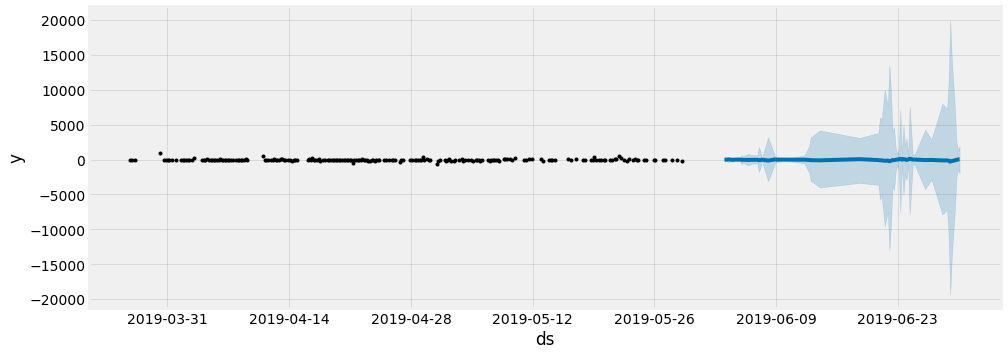

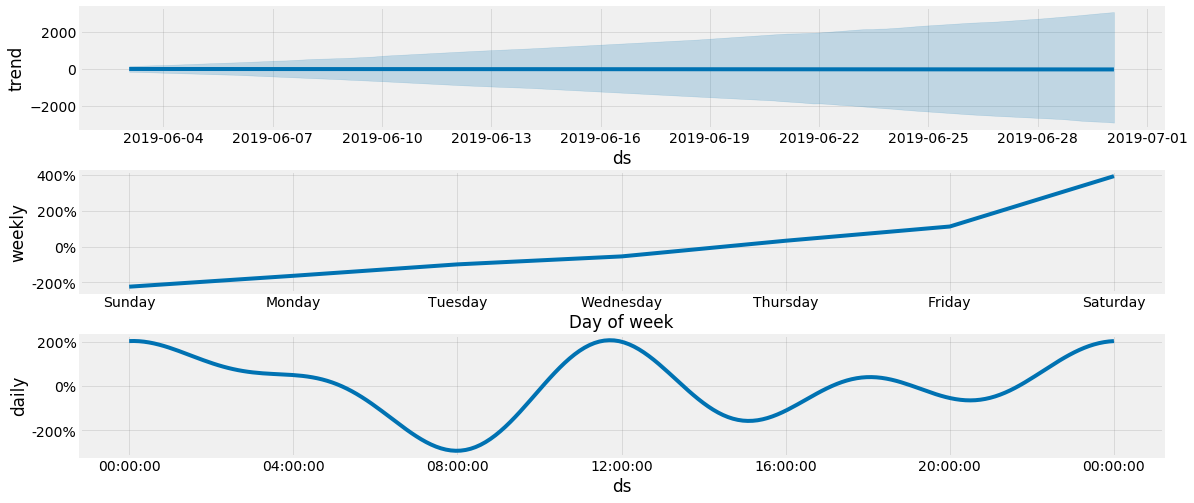

In [36]:
forecast_mT_v4 = mT_v4.predict(df=dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'}))

fig21          = mT_v4.plot(forecast_mT_v4)
fig22          = mT_v4.plot_components(forecast_mT_v4)

fig21.set_figheight(5)
fig21.set_figwidth(15)

fig22.set_figheight(7)
fig22.set_figwidth(19)

In [37]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [38]:
mape = mean_absolute_percentage_error(dataframe_test_CH4dry['Flux'],forecast_mT_v4['yhat'])
print("MAPE",round(mape,4))

MAPE 230.2219


### Compare Forecast vs Actual using resampled data Model

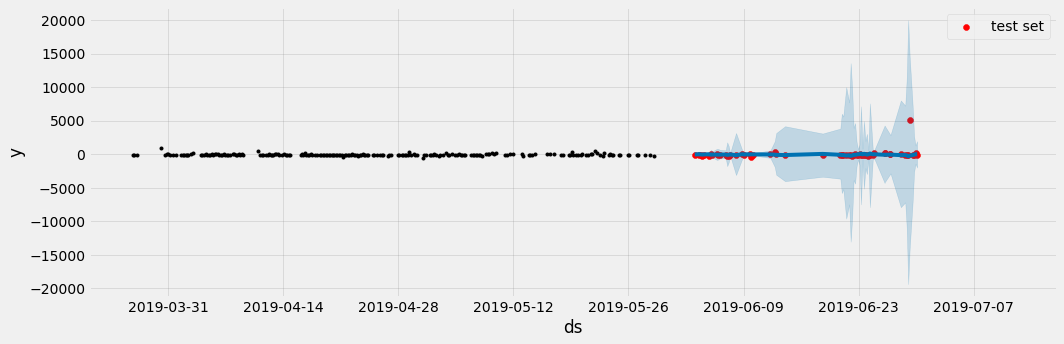

In [39]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_CH4dry.index, dataframe_test_CH4dry['Flux'], color='r', label="test set")
ax.legend()
fig = mT_v4.plot(forecast_mT_v4, ax=ax)

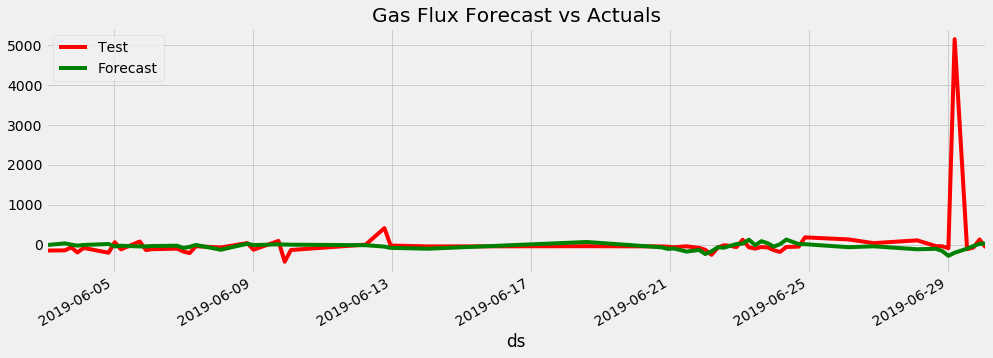

In [40]:
df1=dataframe_test_CH4dry.reset_index().rename(columns={'DateTime': 'ds'})

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df1.plot(kind='line', x='ds', y='Flux', color='red', label='Test', ax=ax)
#X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
forecast_mT_v4.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

In [98]:
#df = df_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})

# Plot the forecast with the actuals
#f1, ax = plt.subplots(1)
#f1.set_figheight(5)
#f1.set_figwidth(15)
#ax.scatter(df.ds, df['y'], color='r', label="test set")
#ax.legend()
##fig2 = m3.plot(X_tst_forecast, ax=ax) 

#fig2 = mT.plot(forecast_test, ax=ax) 

In [ ]:
# Resample from weekly to monthly
#co2_month = CO2.resample('MS').mean()

# Backfill any missing values
#co2_month.fillna(method='bfill', inplace=True)

#co2_month.head()

#### Notes about the different model parameters

##### Multiplicative seasonality
By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. 
This time series has a clear yearly cycle, but the seasonality in the forecast is too large at the start of the time series and too small at the end. In this time series, the seasonality is not a constant additive factor as assumed by Prophet, rather it grows with the trend. This is multiplicative seasonality.

##### Uncertainty in the trend
The biggest source of uncertainty in the forecast is the potential for future trend changes. Prophet is able to detect
and fit these, but what trend changes should we expect moving forward? It’s impossible to know for sure, so we do the
most reasonable thing we can, and we assume that the future will see similar trend changes as the history. 
In particular, we assume that the average frequency and magnitude of trend changes in the future will be the 
same as that which we observe in the history. We project these trend changes forward and by computing their
distribution we obtain uncertainty intervals.

One property of this way of measuring uncertainty is that allowing higher flexibility in the rate, by increasing changepoint_prior_scale, will increase the forecast uncertainty. This is because if we model more rate changes in the history then we will expect more in the future, and makes the uncertainty intervals a useful indicator of overfitting.

the forecasted trend may vary between yhat_lower and yhat_upper

##### Uncertainty in seasonality
To get uncertainty in seasonality, you must do full Bayesian sampling. This is done using the parameter mcmc.samples 
(which defaults to 0). 

### Hide code for printing/visualising purposes

In [37]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')